In [1]:
import re
import pytz
import nltk
import pickle
import community
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.style
import matplotlib.pyplot as plt

from matplotlib import gridspec
from email.parser import Parser
from gensim import corpora, models
from collections import defaultdict
from community import community_louvain
from typing import Dict, List, Tuple, Set
from datetime import datetime, timedelta, timezone
from email.utils import parseaddr, parsedate_to_datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

matplotlib.style.use('default')

# 1. Gender Study

In [ ]:
import pandas as pd

def extract_first_n_lines(input_csv, output_csv, n=10):
    """
    Extract the first n lines of a large CSV file and save them to a new file.

    Parameters:
    - input_csv: str, path to the input CSV file
    - output_csv: str, path to the output CSV file
    - n: int, number of lines to extract (default is 10)
    """
    try:
        # Read the first n lines of the input CSV
        data = pd.read_csv(input_csv, nrows=n)
        
        # Save the extracted lines to a new CSV file
        data.to_csv(output_csv, index=False)
        print(f"Successfully saved the first {n} lines to {output_csv}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
input_csv_path = 'emails.csv'  # Replace with actual path
output_csv_path = 'emails_sample.csv'
extract_first_n_lines(input_csv_path, output_csv_path, n=1000)

## I. Data Processing
In this part, we extracted all the information we want from the cvs file: 
- sender first name
- sender last name
- receiver first name
- receiver last name
- day
- month
- year
- hour
- timezone
- subject
- body
- gender of sender
- gender of receiver

We did not include the emails where any of these information is missing (sending an email to a company, unable to determine gender, time incomplete, subject or body empty, repetitive emails, sender and receiver being the same person)

In [ ]:
import os
import pandas as pd
from datetime import datetime
import gender_guesser.detector as gender
import pickle

# Initialize gender detector
gender_detector = gender.Detector()

# Configuration
csv_file_path = 'emails.csv'  # Replace with the correct path
output_pickle_file = 'emails.pkl'
batch_size = 1000  # Adjust batch size as needed

# Helper function to parse sender/receiver information
def parse_sender_receiver(email):
    if email and "@" in email:
        name_part = email.split("@")[0]
        if "." in name_part:
            first_name, last_name = name_part.split(".", 1)
        else:
            first_name, last_name = name_part, ""
        return first_name.capitalize(), last_name.capitalize()
    return None, ""

# Helper function to parse date and time
def parse_date_time(date_str):
    if date_str:
        try:
            parts = date_str.split()
            return {
                "day": f"{parts[0]} {parts[1]}",
                "month": parts[2],
                "year": parts[3],
                "hour": parts[4],
                "timezone": " ".join(parts[5:])
            }
        except IndexError:
            return {"day": None, "month": None, "year": None, "hour": None, "timezone": None}
    return {"day": None, "month": None, "year": None, "hour": None, "timezone": None}

# Helper function to parse email content
def parse_email_content(content):
    email_data = {
        "sender first name": None,
        "sender last name": "",
        "receiver first name": None,
        "receiver last name": "",
        "day": None,
        "month": None,
        "year": None,
        "hour": None,
        "timezone": None,
        "subject": None,
        "body": None,
        "gender of sender": None,
        "gender of receiver": None
    }
    if not content:
        return email_data

    lines = content.split("\n")
    for line in lines:
        if line.startswith("From:"):
            first_name, last_name = parse_sender_receiver(line.replace("From:", "").strip())
            email_data["sender first name"] = first_name
            email_data["sender last name"] = last_name
        elif line.startswith("To:") and not email_data["receiver first name"]:
            first_name, last_name = parse_sender_receiver(line.replace("To:", "").strip())
            email_data["receiver first name"] = first_name
            email_data["receiver last name"] = last_name
        elif line.startswith("Date:"):
            date_info = parse_date_time(line.replace("Date:", "").strip())
            email_data.update(date_info)
        elif line.startswith("Subject:"):
            email_data["subject"] = line.replace("Subject:", "").strip()

    # Extract email body
    body_start_index = content.find("\n\n")
    email_data["body"] = content[body_start_index + 2:] if body_start_index != -1 else None

    return email_data

# Determine gender using Genderize dataset
def determine_gender(first_name):
    if not first_name:
        return None
    guessed_gender = gender_detector.get_gender(first_name)
    if guessed_gender in ["male", "mostly_male"]:
        return "M"
    elif guessed_gender in ["female", "mostly_female"]:
        return "F"
    return None

# Serialize to Pickle
def save_to_pickle(data, output_file):
    with open(output_file, 'ab') as file:
        pickle.dump(data, file)

# Deserialize from Pickle
def load_from_pickle(input_file):
    data = []
    with open(input_file, 'rb') as file:
        while True:
            try:
                data.append(pickle.load(file))
            except EOFError:
                break
    return data

# Process large dataset sequentially
def process_large_dataset():
    chunk_iterator = pd.read_csv(csv_file_path, chunksize=batch_size)
    seen_emails = set()
    total_processed = 0

    for chunk_index, chunk in enumerate(chunk_iterator):
        print(f"Processing chunk {chunk_index + 1}")
        batch_data = []
        for _, row in chunk.iterrows():
            content = row.get("message", "")
            email_data = parse_email_content(content)

            # Cleaning Criteria
            if not email_data["sender first name"] or not email_data["sender last name"]:
                continue  # Skip if sender is incomplete
            if not email_data["receiver first name"] or not email_data["receiver last name"]:
                continue  # Skip if receiver is incomplete
            if not email_data["subject"] or not email_data["body"]:
                continue  # Skip if subject or body is missing
            if email_data["sender first name"] == email_data["receiver first name"] and email_data["sender last name"] == email_data["receiver last name"]:
                continue  # Skip if sender and receiver are the same
            if not email_data["year"] or not email_data["day"] or not email_data["hour"]:
                continue  # Skip if date or time is incomplete

            # Determine sender and receiver genders
            sender_gender = determine_gender(email_data["sender first name"])
            receiver_gender = determine_gender(email_data["receiver first name"])
            if not sender_gender or not receiver_gender:
                continue  # Skip if gender can't be determined

            email_data["gender of sender"] = sender_gender
            email_data["gender of receiver"] = receiver_gender

            # Check for duplicates based on email body hash
            email_hash = hash(email_data["body"])
            if email_hash in seen_emails:
                continue
            seen_emails.add(email_hash)

            batch_data.append(email_data)

        # Save the batch to pickle file
        save_to_pickle(batch_data, output_pickle_file)
        total_processed += len(batch_data)

    print(f"Total valid emails processed and saved: {total_processed}")

# Run the processing
if __name__ == "__main__":
    process_large_dataset()


Finally, we created 6 file texts:
- emails where the sender is male
- emails where the sender is female
- emails where the sender is male and the receiver is male
- emails where the sender is male and the receiver is female
- emails where the sender is female and the receiver is male
- emails where the sender is female and the receiver is female

In [ ]:
import pickle

# Input Pickle file
pickle_file = 'small.pkl'

# Output text files
output_files = {
    "male_sender": "male_sender.txt",
    "female_sender": "female_sender.txt",
    "male_to_male": "male_to_male.txt",
    "male_to_female": "male_to_female.txt",
    "female_to_male": "female_to_male.txt",
    "female_to_female": "female_to_female.txt"
}

# Initialize text files
for file in output_files.values():
    with open(file, 'w') as f:
        pass  # Clear any existing content

# Process Pickle file and write to text files
def process_emails_for_text_files(pickle_file, output_files):
    with open(pickle_file, 'rb') as file:
        while True:
            try:
                batch = pickle.load(file)
                for email in batch:
                    sender_gender = email.get("gender of sender")
                    receiver_gender = email.get("gender of receiver")
                    body = email.get("body", "").strip()
                    
                    if not body:
                        continue  # Skip if email body is empty
                    
                    if sender_gender == "M":
                        with open(output_files["male_sender"], 'a') as f:
                            f.write(body + "\n")
                        if receiver_gender == "M":
                            with open(output_files["male_to_male"], 'a') as f:
                                f.write(body + "\n")
                        elif receiver_gender == "F":
                            with open(output_files["male_to_female"], 'a') as f:
                                f.write(body + "\n")
                    elif sender_gender == "F":
                        with open(output_files["female_sender"], 'a') as f:
                            f.write(body + "\n")
                        if receiver_gender == "M":
                            with open(output_files["female_to_male"], 'a') as f:
                                f.write(body + "\n")
                        elif receiver_gender == "F":
                            with open(output_files["female_to_female"], 'a') as f:
                                f.write(body + "\n")
            except EOFError:
                break

# Run the function
process_emails_for_text_files(pickle_file, output_files)

print("Text files created successfully:")
for key, file in output_files.items():
    print(f"{key}: {file}")


## II. Sentiment Analysis
### 1. Data Preparation
The text cleaning process ensures the data is in a structured and consistent format without altering its meaning or sentiment.
- Tokenization to split text into individual words.
- Removal of punctuation and special characters while preserving meaningful tokens.
- Lemmatization to normalize words to their root forms.


In [ ]:
import pickle
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Define cleaning functions
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove punctuation and special characters
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens if word.isalpha()]
    
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    
    # Rejoin tokens into cleaned text
    return " ".join(tokens)

# Process and update Pickle file
def clean_and_update_pickle(pickle_file, output_pickle_file):
    updated_batches = []
    
    with open(pickle_file, 'rb') as file:
        while True:
            try:
                batch = pickle.load(file)
                for email in batch:
                    body = email.get("body", "").strip()
                    if body:
                        # Clean the email body
                        email["body"] = clean_text(body)
                updated_batches.append(batch)
            except EOFError:
                break

    # Write cleaned data back to a new Pickle file
    with open(output_pickle_file, 'wb') as file:
        for batch in updated_batches:
            pickle.dump(batch, file)

# Run the cleaning process
input_pickle_file = 'emails.pkl'
output_pickle_file = 'emails_cleaned.pkl'
clean_and_update_pickle(input_pickle_file, output_pickle_file)

print(f"Pickle file '{output_pickle_file}' updated with cleaned email bodies.")


We extract important features from the texts like word count, sentence count, and average word length.

In [ ]:
def extract_text_features_from_pickle(pickle_file):
    word_counts = []
    sentence_counts = []
    avg_word_lengths = []
    
    with open(pickle_file, 'rb') as file:
        while True:
            try:
                batch = pickle.load(file)
                for email in batch:
                    body = email.get("body", "")
                    word_counts.append(len(body.split()))
                    sentence_counts.append(len(re.split(r'[.!?]', body)) - 1)
                    avg_word_lengths.append(
                        sum(len(word) for word in body.split()) / len(body.split()) if body.split() else 0
                    )
            except EOFError:
                break

    return word_counts, sentence_counts, avg_word_lengths

# Extract features from the cleaned Pickle file
word_counts, sentence_counts, avg_word_lengths = extract_text_features_from_pickle(input_pickle_file)
print(f"Word counts: {word_counts[:10]}")
print(f"Sentence counts: {sentence_counts[:10]}")
print(f"Average word lengths: {avg_word_lengths[:10]}")


In [ ]:
import pickle
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex

# Initialize tools
analyzer = SentimentIntensityAnalyzer()
POLITENESS_WORDS = {"please", "thank you", "thanks", "kindly", "appreciate"}
HEDGING_WORDS = {"might", "perhaps", "possibly", "could", "maybe", "seem"}

def process_emails_once(pickle_file):
    # Consolidated data structure
    consolidated_data = {
        "emails": [],  # All emails with necessary data
        "sentiment_by_gender": {"M": [], "F": []},
        "sentiment_by_pair": {"M-M": [], "M-F": [], "F-M": [], "F-F": []},
        "politeness_hedging": {"M": {"politeness": [], "hedging": []}, "F": {"politeness": [], "hedging": []}},
        "emotions_by_gender": {"M": {}, "F": {}},
        "emotions_by_pair": {"M-M": {}, "M-F": {}, "F-M": {}, "F-F": {}},
        "polarity_shifts": {"M-M": 0, "M-F": 0, "F-M": 0, "F-F": 0},
        "total_conversations": {"M-M": 0, "M-F": 0, "F-M": 0, "F-F": 0}
    }

    conversations = {}  # For polarity shift tracking

    # Process the pickle file
    with open(pickle_file, 'rb') as file:
        while True:
            try:
                batch = pickle.load(file)
                for email in batch:
                    body = email.get("body", "").strip()
                    sender_gender = email.get("gender of sender")
                    receiver_gender = email.get("gender of receiver")
                    subject = email.get("subject", "").strip()

                    if not body or not sender_gender or not receiver_gender:
                        continue

                    # Sentiment Analysis
                    sentiment = analyzer.polarity_scores(body)
                    gender_pair = f"{sender_gender}-{receiver_gender}"

                    # Store email data
                    email_data = {
                        "body": body,
                        "sender_gender": sender_gender,
                        "receiver_gender": receiver_gender,
                        "gender_pair": gender_pair,
                        "subject": subject,
                        "sentiment": sentiment
                    }
                    consolidated_data["emails"].append(email_data)

                    # Aggregate Sentiments by Gender
                    consolidated_data["sentiment_by_gender"][sender_gender].append(sentiment)
                    consolidated_data["sentiment_by_pair"][gender_pair].append(sentiment)

                    # Linguistic Features: Politeness and Hedging
                    words = body.lower().split()
                    politeness_count = sum(1 for word in words if word in POLITENESS_WORDS)
                    hedging_count = sum(1 for word in words if word in HEDGING_WORDS)
                    total_words = len(words)
                    politeness_ratio = politeness_count / total_words if total_words > 0 else 0
                    hedging_ratio = hedging_count / total_words if total_words > 0 else 0
                    consolidated_data["politeness_hedging"][sender_gender]["politeness"].append(politeness_ratio)
                    consolidated_data["politeness_hedging"][sender_gender]["hedging"].append(hedging_ratio)

                    # Emotion Detection
                    emotions = NRCLex(body).raw_emotion_scores
                    for emotion, count in emotions.items():
                        # By Gender
                        if emotion not in consolidated_data["emotions_by_gender"][sender_gender]:
                            consolidated_data["emotions_by_gender"][sender_gender][emotion] = 0
                        consolidated_data["emotions_by_gender"][sender_gender][emotion] += count
                        # By Gender Pair
                        if emotion not in consolidated_data["emotions_by_pair"][gender_pair]:
                            consolidated_data["emotions_by_pair"][gender_pair][emotion] = 0
                        consolidated_data["emotions_by_pair"][gender_pair][emotion] += count

                    # Polarity Shifts
                    if subject:
                        if subject not in conversations:
                            conversations[subject] = []
                        conversations[subject].append(sentiment["compound"])

                # Track polarity shifts in conversations
                for subject, compound_scores in conversations.items():
                    for i in range(1, len(compound_scores)):
                        if (compound_scores[i - 1] > 0 and compound_scores[i] < 0) or (compound_scores[i - 1] < 0 and compound_scores[i] > 0):
                            gender_pair = consolidated_data["emails"][i]["gender_pair"]
                            consolidated_data["polarity_shifts"][gender_pair] += 1
                            consolidated_data["total_conversations"][gender_pair] += 1

            except EOFError:
                break

    return consolidated_data

# Run the function to consolidate data
pickle_file = "emails_cleaned.pkl"
consolidated_data = process_emails_once(pickle_file)

print("Data processed and consolidated successfully.")

### 2. Sentiment Analysis:

In [ ]:
import pandas as pd
from collections import defaultdict

# Analyze sentiment for emails and group by gender pair using consolidated_data
def analyze_sentiments_from_consolidated(consolidated_data):
    sentiment_summary = defaultdict(lambda: {
        "positive_sum": 0,
        "neutral_sum": 0,
        "negative_sum": 0,
        "compound_sum": 0,
        "count": 0
    })

    # Iterate over the preprocessed email data in consolidated_data
    for email in consolidated_data["emails"]:
        sentiment = email["sentiment"]
        gender_pair = email["gender_pair"]

        # Aggregate sentiment scores
        sentiment_summary[gender_pair]["positive_sum"] += sentiment["pos"]
        sentiment_summary[gender_pair]["neutral_sum"] += sentiment["neu"]
        sentiment_summary[gender_pair]["negative_sum"] += sentiment["neg"]
        sentiment_summary[gender_pair]["compound_sum"] += sentiment["compound"]
        sentiment_summary[gender_pair]["count"] += 1

    # Calculate averages
    summary = {}
    for gender_pair, stats in sentiment_summary.items():
        count = stats["count"]
        summary[gender_pair] = {
            "positive_avg": stats["positive_sum"] / count if count > 0 else 0,
            "neutral_avg": stats["neutral_sum"] / count if count > 0 else 0,
            "negative_avg": stats["negative_sum"] / count if count > 0 else 0,
            "compound_avg": stats["compound_sum"] / count if count > 0 else 0,
            "count": count
        }

    return summary

# Summarize sentiment scores
def print_summary_statistics(summary):
    print("Sentiment Summary Statistics:")
    for gender_pair, stats in summary.items():
        print(f"{gender_pair}:")
        print(f"  Count: {stats['count']}")
        print(f"  Positive Avg: {stats['positive_avg']:.2f}")
        print(f"  Neutral Avg: {stats['neutral_avg']:.2f}")
        print(f"  Negative Avg: {stats['negative_avg']:.2f}")
        print(f"  Compound Avg: {stats['compound_avg']:.2f}")

# Example usage
# Assuming consolidated_data is already created from the previous processing step
summary_statistics = analyze_sentiments_from_consolidated(consolidated_data)

# Print results
print_summary_statistics(summary_statistics)


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for aggregated text files
def analyze_sentiments_from_files(file_paths):
    sentiment_results = {}

    for gender_pair, file_path in file_paths.items():
        try:
            with open(file_path, 'r') as file:
                text = file.read()
                # Calculate sentiment scores for the aggregated text
                sentiment = analyzer.polarity_scores(text)
                sentiment_results[gender_pair] = sentiment
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return sentiment_results

# Summarize sentiment scores
def summarize_sentiments(sentiment_results):
    summary = []
    for gender_pair, sentiment in sentiment_results.items():
        summary.append({
            "gender_pair": gender_pair,
            "positive_avg": sentiment["pos"],
            "neutral_avg": sentiment["neu"],
            "negative_avg": sentiment["neg"],
            "compound_avg": sentiment["compound"]
        })
    return pd.DataFrame(summary)

# Define file paths for each gender pair
file_paths = {
    "Male-Male": "male_to_male.txt",
    "Male-Female": "male_to_female.txt",
    "Female-Male": "female_to_male.txt",
    "Female-Female": "female_to_female.txt"
}

# Run the analysis
sentiment_results = analyze_sentiments_from_files(file_paths)
summary_statistics = summarize_sentiments(sentiment_results)

# Output summary statistics
print("Sentiment Summary Statistics:")
print(summary_statistics)


Now we compute the average sentiment for all emails send by males and females where each gender is either the sender or the receier

In [ ]:
# Function to calculate sentiment averages by sender gender using consolidated_data
def calculate_avg_sentiment_by_sender_gender_from_consolidated(consolidated_data):
    # Initialize data structure for aggregation
    sentiment_data = {
        "M": {"pos_sum": 0, "neu_sum": 0, "neg_sum": 0, "compound_sum": 0, "count": 0},
        "F": {"pos_sum": 0, "neu_sum": 0, "neg_sum": 0, "compound_sum": 0, "count": 0},
    }

    # Aggregate sentiment scores by sender gender
    for email in consolidated_data["emails"]:
        sender_gender = email["sender_gender"]
        sentiment = email["sentiment"]

        if sender_gender in ["M", "F"]:
            sentiment_data[sender_gender]["pos_sum"] += sentiment["pos"]
            sentiment_data[sender_gender]["neu_sum"] += sentiment["neu"]
            sentiment_data[sender_gender]["neg_sum"] += sentiment["neg"]
            sentiment_data[sender_gender]["compound_sum"] += sentiment["compound"]
            sentiment_data[sender_gender]["count"] += 1

    # Calculate averages
    avg_sentiments = {}
    for gender, scores in sentiment_data.items():
        count = scores["count"]
        avg_sentiments[gender] = {
            "positive_avg": scores["pos_sum"] / count if count > 0 else 0,
            "neutral_avg": scores["neu_sum"] / count if count > 0 else 0,
            "negative_avg": scores["neg_sum"] / count if count > 0 else 0,
            "compound_avg": scores["compound_sum"] / count if count > 0 else 0,
        }

    return avg_sentiments

# Example usage
# Assuming consolidated_data is already created from the previous processing step
avg_sentiments = calculate_avg_sentiment_by_sender_gender_from_consolidated(consolidated_data)

# Output the results
print("Average Sentiment Scores by Sender Gender:")
for gender, scores in avg_sentiments.items():
    print(f"{'Male' if gender == 'M' else 'Female'}:")
    print(f"  Positive Avg: {scores['positive_avg']:.3f}")
    print(f"  Neutral Avg: {scores['neutral_avg']:.3f}")
    print(f"  Negative Avg: {scores['negative_avg']:.3f}")
    print(f"  Compound Avg: {scores['compound_avg']:.3f}")


In [ ]:
# Function to calculate sentiment averages by receiver gender using consolidated_data
def calculate_avg_sentiment_by_receiver_gender_from_consolidated(consolidated_data):
    # Initialize data structure for aggregation
    sentiment_data = {
        "M": {"pos_sum": 0, "neu_sum": 0, "neg_sum": 0, "compound_sum": 0, "count": 0},
        "F": {"pos_sum": 0, "neu_sum": 0, "neg_sum": 0, "compound_sum": 0, "count": 0},
    }

    # Aggregate sentiment scores by receiver gender
    for email in consolidated_data["emails"]:
        receiver_gender = email["receiver_gender"]
        sentiment = email["sentiment"]

        if receiver_gender in ["M", "F"]:
            sentiment_data[receiver_gender]["pos_sum"] += sentiment["pos"]
            sentiment_data[receiver_gender]["neu_sum"] += sentiment["neu"]
            sentiment_data[receiver_gender]["neg_sum"] += sentiment["neg"]
            sentiment_data[receiver_gender]["compound_sum"] += sentiment["compound"]
            sentiment_data[receiver_gender]["count"] += 1

    # Calculate averages
    avg_sentiments = {}
    for gender, scores in sentiment_data.items():
        count = scores["count"]
        avg_sentiments[gender] = {
            "positive_avg": scores["pos_sum"] / count if count > 0 else 0,
            "neutral_avg": scores["neu_sum"] / count if count > 0 else 0,
            "negative_avg": scores["neg_sum"] / count if count > 0 else 0,
            "compound_avg": scores["compound_sum"] / count if count > 0 else 0,
        }

    return avg_sentiments

# Example usage
# Assuming consolidated_data is already created from the previous processing step
avg_sentiments = calculate_avg_sentiment_by_receiver_gender_from_consolidated(consolidated_data)

# Output the results
print("Average Sentiment Scores by Receiver Gender:")
for gender, scores in avg_sentiments.items():
    print(f"{'Male' if gender == 'M' else 'Female'}:")
    print(f"  Positive Avg: {scores['positive_avg']:.3f}")
    print(f"  Neutral Avg: {scores['neutral_avg']:.3f}")
    print(f"  Negative Avg: {scores['negative_avg']:.3f}")
    print(f"  Compound Avg: {scores['compound_avg']:.3f}")


## III. Comparative Analysis
Now lets compare the mean and median sentiment scores for emails and perform statistical tests to determine whether the observed differences are significant.

In [ ]:
from scipy.stats import ttest_ind
import numpy as np

# Function to extract compound sentiment scores by gender from consolidated_data
def extract_sentiment_data_by_gender(consolidated_data, gender_key):
    data = {"M": {"compound": []}, "F": {"compound": []}}

    for email in consolidated_data["emails"]:
        gender = email[gender_key]
        sentiment = email["sentiment"]

        if gender in ["M", "F"]:
            data[gender]["compound"].append(sentiment["compound"])

    return data

# Function to compute mean, median, and perform t-tests
def compute_comparison(data):
    results = {}
    male_scores = np.array(data["M"]["compound"])
    female_scores = np.array(data["F"]["compound"])

    results["male_mean"] = male_scores.mean()
    results["female_mean"] = female_scores.mean()
    results["male_median"] = np.median(male_scores)
    results["female_median"] = np.median(female_scores)

    # Perform t-test
    t_stat, p_value = ttest_ind(male_scores, female_scores, equal_var=False)
    results["t_stat"] = t_stat
    results["p_value"] = p_value

    return results

# Analyze by sender gender
print("Comparing Sentiments by Sender Gender...")
sender_data = extract_sentiment_data_by_gender(consolidated_data, "sender_gender")
sender_results = compute_comparison(sender_data)
print(f"Male Mean: {sender_results['male_mean']:.3f}, Female Mean: {sender_results['female_mean']:.3f}")
print(f"Male Median: {sender_results['male_median']:.3f}, Female Median: {sender_results['female_median']:.3f}")
print(f"T-Statistic: {sender_results['t_stat']:.3f}, P-Value: {sender_results['p_value']:.3f}")

# Analyze by receiver gender
print("\nComparing Sentiments by Receiver Gender...")
receiver_data = extract_sentiment_data_by_gender(consolidated_data, "receiver_gender")
receiver_results = compute_comparison(receiver_data)
print(f"Male Mean: {receiver_results['male_mean']:.3f}, Female Mean: {receiver_results['female_mean']:.3f}")
print(f"Male Median: {receiver_results['male_median']:.3f}, Female Median: {receiver_results['female_median']:.3f}")
print(f"T-Statistic: {receiver_results['t_stat']:.3f}, P-Value: {receiver_results['p_value']:.3f}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate sentiment scores for gender pairs using consolidated_data
def analyze_sentiments_by_gender_pair_from_consolidated(consolidated_data):
    # Initialize data structure
    gender_pair_data = {
        "M-M": {"compound": []},
        "M-F": {"compound": []},
        "F-M": {"compound": []},
        "F-F": {"compound": []}
    }

    # Aggregate sentiment scores by gender pair
    for email in consolidated_data["emails"]:
        sender_gender = email["sender_gender"]
        receiver_gender = email["receiver_gender"]
        sentiment = email["sentiment"]

        if sender_gender in ["M", "F"] and receiver_gender in ["M", "F"]:
            gender_pair = f"{sender_gender}-{receiver_gender}"
            gender_pair_data[gender_pair]["compound"].append(sentiment["compound"])

    return gender_pair_data

# Function to summarize and plot sentiment distributions
def summarize_and_plot_gender_pair_sentiments(gender_pair_data):
    # Prepare a DataFrame for easy analysis
    summary = []
    for gender_pair, data in gender_pair_data.items():
        scores = data["compound"]
        summary.append({
            "gender_pair": gender_pair,
            "mean": sum(scores) / len(scores) if scores else 0,
            "median": pd.Series(scores).median() if scores else 0,
            "count": len(scores)
        })

    summary_df = pd.DataFrame(summary)

    # Plot sentiment distribution
    plt.figure(figsize=(10, 6))
    for gender_pair, data in gender_pair_data.items():
        plt.hist(data["compound"], bins=20, alpha=1, label=gender_pair)

    plt.title("Sentiment Score Distributions by Gender Pair")
    plt.xlabel("Compound Sentiment Score")
    plt.ylabel("Frequency")
    plt.legend(title="Gender Pair")
    plt.grid(axis="y", linestyle="--", alpha=1)
    plt.show()

    return summary_df

# Example usage
# Assuming consolidated_data is already created from the previous processing step
gender_pair_data = analyze_sentiments_by_gender_pair_from_consolidated(consolidated_data)
summary_df = summarize_and_plot_gender_pair_sentiments(gender_pair_data)

# Output summary
print("Sentiment Summary by Gender Pair:")
print(summary_df)


## IV. Advances Analysis
### 1. Emotion Detection:
Using the NRC Emotion Lexicon, let's detect emotions (joy, anger, sadness, etc.) from the text and compare emotion distributions by gender and gender pairs.

In [ ]:
from nrclex import NRCLex
import pandas as pd
import matplotlib.pyplot as plt

# Helper function to analyze emotions in text
def analyze_emotions(text):
    nrc = NRCLex(text)
    return nrc.raw_emotion_scores

# Process emails to extract emotions by gender or gender pair
def analyze_emotions_from_consolidated(consolidated_data, group_by):
    emotion_data = {}

    for email in consolidated_data["emails"]:
        body = email["body"]
        sender_gender = email["sender_gender"]
        receiver_gender = email["receiver_gender"]

        if not body:
            continue

        if group_by == "gender":
            group_key = sender_gender
        elif group_by == "gender_pair":
            group_key = f"{sender_gender}-{receiver_gender}"
        else:
            raise ValueError("Invalid group_by value. Use 'gender' or 'gender_pair'.")

        if group_key not in emotion_data:
            emotion_data[group_key] = {
                "joy": 0, "anger": 0, "sadness": 0, "fear": 0,
                "anticipation": 0, "disgust": 0, "surprise": 0, "trust": 0
            }

        # Analyze emotions
        emotions = analyze_emotions(body)
        for emotion, count in emotions.items():
            if emotion in emotion_data[group_key]:
                emotion_data[group_key][emotion] += count

    return emotion_data

# Normalize and plot emotion distributions
def plot_emotion_distributions(emotion_data, title):
    df = pd.DataFrame.from_dict(emotion_data, orient="index")
    df_normalized = df.div(df.sum(axis=1), axis=0)  # Normalize for comparison

    # Plot
    df_normalized.T.plot(kind="bar", figsize=(12, 6))
    plt.title(title)
    plt.ylabel("Proportion")
    plt.xlabel("Emotion")
    plt.xticks(rotation=45)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df_normalized

# Example usage
# Assuming consolidated_data is already created from the previous processing step
# Analyze by gender
emotion_data_gender = analyze_emotions_from_consolidated(consolidated_data, group_by="gender")
normalized_gender = plot_emotion_distributions(emotion_data_gender, "Emotion Distribution by Gender")

# Analyze by gender pair
emotion_data_gender_pair = analyze_emotions_from_consolidated(consolidated_data, group_by="gender_pair")
normalized_gender_pair = plot_emotion_distributions(emotion_data_gender_pair, "Emotion Distribution by Gender Pair")

# Print normalized data for insights
print("Normalized Emotion Distribution by Gender:")
print(normalized_gender)
print("\nNormalized Emotion Distribution by Gender Pair:")
print(normalized_gender_pair)


### 2. Polarity Analysis:
Let's identify polarity shifts (e.g., positive to negative) within conversations between genders and compare polarity shifts between gender pairs.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Helper function to extract polarity shift
def identify_polarity_shifts_from_consolidated(consolidated_data):
    shifts = {"M-M": 0, "M-F": 0, "F-M": 0, "F-F": 0}
    total_conversations = {"M-M": 0, "M-F": 0, "F-M": 0, "F-F": 0}

    # Group emails by subject to simulate conversations
    conversations = {}
    for email in consolidated_data["emails"]:
        subject = email.get("subject", "").strip()
        if subject:
            if subject not in conversations:
                conversations[subject] = []
            conversations[subject].append(email)

    # Process each conversation
    for subject, convo_emails in conversations.items():
        # Sort by timestamp (day, hour, etc.)
        convo_emails = sorted(
            convo_emails, 
            key=lambda x: (
                x.get("year"), 
                x.get("month"), 
                x.get("day"), 
                x.get("hour")
            )
        )

        prev_polarity = None
        prev_gender_pair = None

        for email in convo_emails:
            body = email.get("body", "").strip()
            sender_gender = email.get("sender_gender")
            receiver_gender = email.get("receiver_gender")

            if body and sender_gender in ["M", "F"] and receiver_gender in ["M", "F"]:
                # Retrieve precomputed sentiment polarity
                polarity = email["sentiment"]["compound"]
                gender_pair = f"{sender_gender}-{receiver_gender}"

                if prev_polarity is not None and prev_gender_pair == gender_pair:
                    # Check for polarity shift
                    if (prev_polarity > 0 and polarity < 0) or (prev_polarity < 0 and polarity > 0):
                        shifts[gender_pair] += 1

                prev_polarity = polarity
                prev_gender_pair = gender_pair
                total_conversations[gender_pair] += 1

    return shifts, total_conversations

# Plot polarity shifts
def plot_polarity_shifts(shifts, total_conversations):
    # Normalize polarity shifts to proportions
    proportions = {key: shifts[key] / total_conversations[key] if total_conversations[key] > 0 else 0 for key in shifts}

    # Convert to DataFrame for visualization
    df = pd.DataFrame({
        "Gender Pair": shifts.keys(),
        "Polarity Shifts": shifts.values(),
        "Total Conversations": total_conversations.values(),
        "Proportion": proportions.values()
    })

    # Plot proportions
    df.plot(x="Gender Pair", y="Proportion", kind="bar", legend=False, figsize=(10, 6))
    plt.title("Proportion of Polarity Shifts by Gender Pair")
    plt.ylabel("Proportion of Conversations with Polarity Shifts")
    plt.xlabel("Gender Pair")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
    return df

# Example usage
# Assuming consolidated_data is already created from the previous processing step
shifts, total_conversations = identify_polarity_shifts_from_consolidated(consolidated_data)
df_shifts = plot_polarity_shifts(shifts, total_conversations)

# Print table with results
print("Polarity Shift Analysis:")
print(df_shifts.round(3))

### 3. Linguistic Features and Sentiment:
Now let's analyze linguistic features (e.g., politeness, hedging) and their relationship with sentiment scores, for exampleare polite emails associated with any gender?


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define linguistic feature lexicons
POLITENESS_WORDS = {"please", "thank you", "thanks", "kindly", "appreciate"}
HEDGING_WORDS = {"might", "perhaps", "possibly", "could", "maybe", "seem"}

# Helper function to extract linguistic features
def extract_linguistic_features(body):
    words = body.lower().split()
    politeness_count = sum(1 for word in words if word in POLITENESS_WORDS)
    hedging_count = sum(1 for word in words if word in HEDGING_WORDS)
    total_words = len(words)
    
    return {
        "politeness_ratio": politeness_count / total_words if total_words > 0 else 0,
        "hedging_ratio": hedging_count / total_words if total_words > 0 else 0
    }

# Analyze linguistic features and sentiment from consolidated_data
def analyze_linguistic_features_from_consolidated(consolidated_data):
    results = {"M": {"politeness": [], "hedging": [], "sentiment": []},
               "F": {"politeness": [], "hedging": [], "sentiment": []}}
    
    for email in consolidated_data["emails"]:
        body = email["body"]
        sender_gender = email["sender_gender"]

        if body and sender_gender in ["M", "F"]:
            sentiment = email["sentiment"]
            features = extract_linguistic_features(body)
            
            results[sender_gender]["politeness"].append(features["politeness_ratio"])
            results[sender_gender]["hedging"].append(features["hedging_ratio"])
            results[sender_gender]["sentiment"].append(sentiment["compound"])

    return results

# Visualize relationships between linguistic features and sentiment
def visualize_linguistic_features(results):
    df = pd.DataFrame({
        "Gender": ["Male"] * len(results["M"]["politeness"]) + ["Female"] * len(results["F"]["politeness"]),
        "Politeness Ratio": results["M"]["politeness"] + results["F"]["politeness"],
        "Hedging Ratio": results["M"]["hedging"] + results["F"]["hedging"],
        "Compound Sentiment": results["M"]["sentiment"] + results["F"]["sentiment"]
    })

    # Plot politeness vs. sentiment
    plt.figure(figsize=(12, 6))
    for gender in ["Male", "Female"]:
        subset = df[df["Gender"] == gender]
        plt.scatter(subset["Politeness Ratio"], subset["Compound Sentiment"], label=gender, alpha=0.6)
    
    plt.title("Politeness vs. Sentiment by Gender")
    plt.xlabel("Politeness Ratio")
    plt.ylabel("Compound Sentiment")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig("politness.png")
    plt.show()
    

    # Plot hedging vs. sentiment
    plt.figure(figsize=(12, 6))
    for gender in ["Male", "Female"]:
        subset = df[df["Gender"] == gender]
        plt.scatter(subset["Hedging Ratio"], subset["Compound Sentiment"], label=gender, alpha=0.6)
    
    plt.title("Hedging vs. Sentiment by Gender")
    plt.xlabel("Hedging Ratio")
    plt.ylabel("Compound Sentiment")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig("hedging.png")
    plt.show()
    

    return df

# Example usage
# Assuming consolidated_data is already created from the previous processing step
linguistic_results = analyze_linguistic_features_from_consolidated(consolidated_data)
df_linguistic = visualize_linguistic_features(linguistic_results)

# Summarize the data
summary = df_linguistic.groupby("Gender").mean()
print("Average Linguistic Features and Sentiment by Gender:")
print(summary)


## V. Visualuzation:
Let's visualize all the data we've collected

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sentiment Distribution - Bar Chart for Each Gender Pair
def plot_sentiment_distribution_by_gender_pair(df_linguistic):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_linguistic, x="Compound Sentiment", hue="Gender", kde=True, bins=30, alpha=0.6)
    plt.title("Sentiment Distribution by Gender")
    plt.xlabel("Compound Sentiment Score")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig("sent_distr.png")
    plt.show()
    

# 2. Violin Plot for Sentiment Score Distributions by Gender
def plot_violin_sentiment_distribution(df_linguistic):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_linguistic, x="Gender", y="Compound Sentiment", inner="quartile", hue="Gender", palette="muted", dodge=False)
    plt.title("Overall Sentiment Score Distribution by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Compound Sentiment Score")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig("overall_sent_distr.png")
    plt.show()
    

# 3. Emotion Distributions - Stacked Bar Chart by Gender
def plot_emotion_distributions_by_gender(normalized_gender):
    normalized_gender.plot(kind="bar", stacked=True, figsize=(10, 6), alpha=0.8, cmap="viridis")
    plt.title("Emotion Proportion Distribution by Gender")
    plt.ylabel("Proportion")
    plt.xlabel("Emotion")
    plt.xticks(rotation=45)
    plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig("emo_dist_gender.png")
    plt.show()
    

# 4. Emotion Distributions - Stacked Bar Chart by Gender Pair
def plot_emotion_distributions_by_gender_pair(normalized_gender_pair):
    normalized_gender_pair.plot(kind="bar", stacked=True, figsize=(10, 6), alpha=0.8, cmap="viridis")
    plt.title("Emotion Proportion Distribution by Gender Pair")
    plt.ylabel("Proportion")
    plt.xlabel("Emotion")
    plt.xticks(rotation=45)
    plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig("emo_dist_gender_pair.png")
    plt.show()
    


# 5. Polarity Shifts - Bar Plot
def plot_polarity_shifts(df_shifts):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_shifts, x="Gender Pair", y="Proportion", hue="Gender Pair", palette="muted", dodge=False)
    plt.title("Polarity Shifts Proportion by Gender Pair")
    plt.xlabel("Gender Pair")
    plt.ylabel("Proportion of Conversations with Polarity Shifts")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Gender Pair", loc="upper right")
    plt.tight_layout()
    plt.savefig("pola_shift_gender.png")
    plt.show()


# Run the visualizations
print("Visualizations:")
plot_sentiment_distribution_by_gender_pair(df_linguistic)
plot_violin_sentiment_distribution(df_linguistic)
plot_emotion_distributions_by_gender(normalized_gender)
plot_emotion_distributions_by_gender_pair(normalized_gender_pair)
plot_polarity_shifts(df_shifts)

# 2. Identifying Influential Roles

In [ ]:
def extract_date_from_message(message: str) -> datetime:
    """
    Extract the date from the email message.
    
    Args:
        message (str): The raw email message.
    
    Returns:
        datetime: The extracted date.
    """
    date_pattern = re.compile(r'Date: (.+)')
    match = date_pattern.search(message)
    if match:
        date_str = match.group(1).strip()
        try:
            return pd.to_datetime(date_str)
        except Exception as e:
            print(f"Error parsing date: {e}")
            return None
    return None

def split_csv_by_calendar_years(csv_path: str) -> tuple:
    """
    Split the CSV file into CSV files corresponding to calendar years from 1985 to 2007.
    
    Args:
        csv_path (str): Path to the CSV file containing email data.
    
    Returns:
        tuple: A tuple containing a list of filenames of the generated CSV files and a list of time labels.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Extract the date from the message column
    df['date'] = df['message'].apply(extract_date_from_message)
    
    # Drop rows with missing dates
    df = df.dropna(subset=['date'])
    
    # Convert the date column to timezone-naive
    df['date'] = df['date'].apply(lambda x: x.tz_localize(None) if x.tzinfo is not None else x)
    
    # Define the calendar year range
    start_year = 1999
    end_year = 2002
    years = list(range(start_year, end_year + 1))
    
    filenames = [] # List to store the filenames of the generated CSV files
    time_labels = [] # List to store the time labels
    
    # Split the DataFrame into calendar years and save each chunk to a new CSV file
    for year in years:
        start_date = pd.to_datetime(f'{year}-01-01').tz_localize(None)
        end_date = pd.to_datetime(f'{year}-12-31').tz_localize(None)
        chunk_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        filename = f'emails_{year}.csv'
        chunk_df.to_csv(filename, index=False)
        filenames.append(filename)
        time_labels.append(f'{year}')
        print(f'Saved emails for year {year} with {len(chunk_df)} records.')
    
    return filenames, time_labels


In [ ]:
class EnronEmailNetwork:
    def __init__(self, emails_csv_path: str):
        """
        Initialize the EnronEmailNetwork with the path to the emails CSV file.
        
        Args:
            emails_csv_path (str): Path to the CSV file containing email data
        """
        self.emails_df = pd.read_csv(emails_csv_path)
        self.graph = nx.DiGraph()  # Directed graph for email communications
        
        self.email_parser = Parser()
        self.employee_attributes = defaultdict(dict)
        self.processed_emails = 0
        self.email_counts = defaultdict(int)  # Track total emails between pairs
        
        # Track directional email counts for degree distribution analysis
        self.sent_counts = defaultdict(int)
        self.received_counts = defaultdict(int)
        
    def parse_email_header(self, message: str) -> Dict:
        """
        Parse email headers to extract relevant information.
        
        Args:
            message (str): Raw email message
            
        Returns:
            Dict: Dictionary containing parsed email metadata
        """
        try:
            # Split headers and body
            headers = {}
            for line in message.split('\n'):
                if line.startswith('X-') or line.startswith('Message-ID') or \
                   line.startswith('Date') or line.startswith('From') or \
                   line.startswith('To') or line.startswith('Subject'):
                    try:
                        key, value = line.split(': ', 1)
                        headers[key.strip()] = value.strip()
                    except ValueError:
                        continue
            return headers
        except Exception as e:
            print(f"Error parsing email: {e}")
            return {}

    def extract_email_addresses(self, address_string: str) -> Set[str]:
        """
        Extract email addresses from a string.
        
        Args:
            address_string (str): String containing email addresses
            
        Returns:
            Set[str]: Set of extracted email addresses
        """
        email_pattern = r'[\w\.-]+@[\w\.-]+\.\w+'
        return set(re.findall(email_pattern, address_string.lower()))

    def build_network(self):
        """
        Build the email communication network and track directional information.
        """
        for _, row in self.emails_df.iterrows():
            headers = self.parse_email_header(row['message'])
            
            if not headers:
                continue
                
            sender = None
            recipients = set()
            
            # Extract sender
            if 'From' in headers:
                sender_addresses = self.extract_email_addresses(headers['From'])
                if sender_addresses:
                    sender = list(sender_addresses)[0]
            
            # Extract recipients
            if 'To' in headers:
                recipients.update(self.extract_email_addresses(headers['To']))
            
            if sender and recipients:
                # Store employee attributes
                self.employee_attributes[sender]['department'] = headers.get('X-Origin', '')
                self.employee_attributes[sender]['role'] = headers.get('X-From', '').split('\n')[0]
                
                # Track directional email counts
                self.sent_counts[sender] += len(recipients)
                for recipient in recipients:
                    self.received_counts[recipient] += 1
                    
                    # Count total (directed) emails between each pair
                    self.email_counts[(sender, recipient)] += 1 # directed graph
                    
            self.processed_emails += 1

        # Build the directed network with final weights
        for (sender, recipient), weight in self.email_counts.items():
            self.graph.add_node(sender, **self.employee_attributes[sender])
            self.graph.add_node(recipient, **self.employee_attributes[recipient])
            self.graph.add_edge(sender, recipient, weight=weight)
            
        print(f"Number of emails in the network (sum of edge weights) before filtering: {sum(d['weight'] for u, v, d in self.graph.edges(data=True))}")
            
        # Remove external email nodes
        external_emails = [node for node in self.graph.nodes if not node.endswith('@enron.com')]
        self.graph.remove_nodes_from(external_emails)
        
        print(f"Number of emails in the network (sum of edge weights) after removing external emails: {sum(d['weight'] for u, v, d in self.graph.edges(data=True))}")
        
        # Remove group email (distribution list) nodes
        pattern = re.compile(r'(^\d|all.|all_|team|office|group|dl-|marketing|support|everyone)') # Common group email patterns & emails starting with a number
        group_emails = [node for node in self.graph.nodes if pattern.match(node.split('@')[0])]
        self.graph.remove_nodes_from(group_emails)
        
        print(f"Number of emails in the network (sum of edge weights) after removing mailing list emails: {sum(d['weight'] for u, v, d in self.graph.edges(data=True))}")
        
        # Remove the nodes with no incoming or outgoing edges
        isolated_nodes = [node for node in self.graph.nodes if self.graph.in_degree(node) == 0 and self.graph.out_degree(node) == 0]
        self.graph.remove_nodes_from(isolated_nodes)

    def sum_edge_weights(self) -> int:
        """
        Sum all the edge weights in the graph.
    
        Returns:
        int: Total sum of all edge weights, which should be equal to the number of emails.
        """
        total_weight = sum(d['weight'] for u, v, d in self.graph.edges(data=True))
        return total_weight
    
    def get_network_stats(self) -> Dict:
        """
        Calculate and return various network statistics.
        
        Returns:
            Dict: Dictionary containing network statistics
        """
        stats = {
            'num_nodes': self.graph.number_of_nodes(),
            'num_edges': self.graph.number_of_edges(),
            'density': nx.density(self.graph),
            'average_clustering': nx.average_clustering(self.graph),
        }
        
        # Calculate degree and strength distributions
        degrees = [d for n, d in self.graph.degree()]
        strengths = [d for n, d in self.graph.degree(weight='weight')]
        
        stats.update({
            'avg_degree': sum(degrees) / len(degrees) if degrees else 0,
            'max_degree': max(degrees) if degrees else 0,
            'avg_strength': sum(strengths) / len(strengths) if strengths else 0,
            'max_strength': max(strengths) if strengths else 0
        })
        
        return stats

The next cell has the code to get create a csv file filtered_emails.csv with a version of the dataset where there are no impossible dates (those emails are deleted).

In [ ]:
# Load the CSV file
csv_path = 'emails.csv'
df = pd.read_csv(csv_path)

# Extract the date from the message column
df['date'] = df['message'].apply(extract_date_from_message)

# Drop rows with missing dates
df = df.dropna(subset=['date'])

# Convert the date column to timezone-naive
df['date'] = df['date'].apply(lambda x: x.tz_localize(None) if x.tzinfo is not None else x)

# Define the date range
start_date = pd.to_datetime('1985-07-16')
end_date = pd.to_datetime('2007-03-01')

# Filter emails within the specified date range
df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Save the filtered DataFrame back to a CSV file
filtered_csv_path = 'filtered_emails.csv'
df_filtered.to_csv(filtered_csv_path, index=False)

print(f"Filtered emails saved to {filtered_csv_path}")

In [ ]:
def analyze_metric_over_time(metric_func, top_n, filenames_dates, metric_name):
    """
    Analyze a specified metric over time chunks and display the highest-ranking node's email addresses for each chunk.
    
    Args:
        metric_func (function): The metric function to apply to the network (e.g., nx.pagerank, nx.betweenness_centrality).
        top_n (int): The number of top nodes to look at.
        filenames_dates (tuple): A tuple containing a list of filenames of the generated CSV files and a list of time labels.
        metric_name (str): The name of the metric being analyzed.
    """
    filenames, time_labels = filenames_dates
    
    for i, filename in enumerate(filenames):
        # Create the EnronEmailNetwork instance and build the network
        enron_network = EnronEmailNetwork(filename)
        enron_network.build_network()
        G = enron_network.graph
        
        if 'outlook.team@enron.com' in G:
            G.remove_node('outlook.team@enron.com')
        
        # Calculate the specified metric
        metric = metric_func(G)
        
        # If the metric is a dictionary (like pagerank or betweenness), sort and get the top nodes
        if isinstance(metric, dict):
            top_nodes = sorted(metric.items(), key=lambda x: x[1], reverse=True)[:top_n]
        # If the metric is a degree view, convert to a dictionary and sort
        elif isinstance(metric, nx.classes.reportviews.DiDegreeView):
            metric = dict(metric)
            top_nodes = sorted(metric.items(), key=lambda x: x[1], reverse=True)[:top_n]
        else:
            raise ValueError("Unsupported metric type")
        
        # Display the highest-ranking node's email addresses for the current chunk of time
        print(f"Top {top_n} nodes for year {time_labels[i]} ({metric_name}):")
        for node, value in top_nodes:
            print(f"  {node}, value: {value}")
        print()
        
        # # Plot the network
        # plt.figure(figsize=(12, 8))
        # pos = nx.spring_layout(G)
        
        # # Draw all nodes
        # nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=100, alpha=0.6)
        
        # # Highlight top nodes
        # top_node_labels = {node: node for node, _ in top_nodes}
        # nx.draw_networkx_nodes(G, pos, nodelist=top_node_labels.keys(), node_color='red', node_size=300, alpha=0.8)
        
        # # Draw edges
        # nx.draw_networkx_edges(G, pos, edge_color='lightgrey', alpha=0.4, arrows=True)
        
        # # Draw labels for top nodes
        # nx.draw_networkx_labels(G, pos, labels=top_node_labels, font_size=16)
        
        # # Add legend
        # legend_elements = [Line2D([0], [0], marker='o', color='w', label='Top 10 Nodes', markerfacecolor='red', markersize=18)]
        # plt.legend(handles=legend_elements, loc='upper right', fontsize=18)
        # plt.title(f'Enron Email Network ({time_labels[i]}) - {metric_name}', fontsize=24)
        # plt.axis('off')
        # plt.tight_layout()
        # plt.savefig(f'network_{time_labels[i]}_{metric_name}.jpg', format='jpg')
        # plt.show()

# Example usage
filenames_dates = split_csv_by_calendar_years('filtered_emails.csv')

n_top_employees = 10

# Analyze PageRank over time
print("PageRank over time:")
analyze_metric_over_time(lambda G: nx.pagerank(G, weight='weight'), n_top_employees, filenames_dates, 'PageRank')

# Analyze Betweenness Centrality over time
print("Betweenness Centrality over time:")
analyze_metric_over_time(nx.betweenness_centrality, n_top_employees, filenames_dates, 'Betweenness Centrality')

# Analyze Out-Degree over time
print("Out-Degree over time:")
analyze_metric_over_time(lambda G: G.out_degree(), n_top_employees, filenames_dates, 'Out-Degree')

# 3. Topic Modeling and Risk Analysis

In [ ]:
class EnronEmailNetwork:
    def __init__(self, emails_csv_path: str):
        """
        Initialize the EnronEmailNetwork with the path to the emails CSV file.
        
        Args:
            emails_csv_path (str): Path to the CSV file containing email data
        """
        self.emails_df = pd.read_csv(emails_csv_path) if emails_csv_path else None
        self.graph = nx.Graph()  # Undirected graph for email communications
        self.email_parser = Parser()
        self.employee_attributes = defaultdict(dict)
        self.processed_emails = 0
        self.email_counts = defaultdict(int)  # Track total emails between pairs
        
        # Track directional email counts for degree distribution analysis
        self.sent_counts = defaultdict(int)
        self.received_counts = defaultdict(int)
        
        self.topic_model = None
        self.vectorizer = None
        self.community_topics = {}
        
        self._setup_nltk()
    
    def _setup_nltk(self):
        """
        Set up NLTK requirements and handle downloads properly.
        """
        required_packages = [
            'punkt',
            'stopwords'
        ]
        
        for package in required_packages:
            try:
                nltk.data.find(f'tokenizers/{package}')
            except LookupError:
                print(f"Downloading required NLTK package: {package}")
                nltk.download(package, quiet=True)
    
        
    def parse_email_header(self, message: str) -> Dict:
        """
        Parse email headers to extract relevant information.
        
        Args:
            message (str): Raw email message
            
        Returns:
            Dict: Dictionary containing parsed email metadata
        """
        try:
            # Split headers and body
            headers = {}
            for line in message.split('\n'):
                if line.startswith('X-') or line.startswith('Message-ID') or \
                   line.startswith('Date') or line.startswith('From') or \
                   line.startswith('To') or line.startswith('Subject'):
                    try:
                        key, value = line.split(': ', 1)
                        headers[key.strip()] = value.strip()
                    except ValueError:
                        continue
            return headers
        except Exception as e:
            print(f"Error parsing email: {e}")
            return {}

    def extract_email_addresses(self, address_string: str) -> Set[str]:
        """
        Extract email addresses from a string.
        
        Args:
            address_string (str): String containing email addresses
            
        Returns:
            Set[str]: Set of extracted email addresses
        """
        email_pattern = r'[\w\.-]+@[\w\.-]+\.\w+'
        return set(re.findall(email_pattern, address_string.lower()))

    def preprocess_dataset(self):
        """
        Preprocess the email dataset by:
        1. Removing emails from outside the Enron domain
        2. Filtering out mailing lists
        3. Removing automated system emails
        4. Standardizing email addresses
        """
        # Filter for Enron domain emails
        def is_enron_email(email):
            return email.endswith('@enron.com')
        
        # Filter out common mailing list patterns
        def is_mailing_list(email):
            mailing_list_patterns = [
                'all.worldwide@enron.com',
                'all.houston@enron.com',
                'announcement', 'announcements',
                'list.', 'dl-', 'distribution'
            ]
            return any(pattern in email.lower() for pattern in mailing_list_patterns)
        
        # Filter out system emails
        def is_system_email(headers):
            system_patterns = [
                'system.administrator',
                'postmaster@',
                'mailer-daemon@',
                'automated.'
            ]
            from_addr = headers.get('From', '').lower()
            return any(pattern in from_addr for pattern in system_patterns)
        
        def parse_date(date_str):
            try:
                # Common date formats in Enron dataset
                date_patterns = [
                    r'(?P<day>\d{1,2})\s+(?P<month>[A-Za-z]+)\s+(?P<year>\d{4})',  # "11 Oct 2001"
                    r'(?P<month>[A-Za-z]+)\s+(?P<day>\d{1,2}),?\s+(?P<year>\d{4})',  # "Oct 11, 2001" or "Oct 11 2001"
                    r'(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})'  # "2001-10-11"
                ]
                
                # Month name to number mapping
                month_map = {
                    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
                }
                
                if not date_str:
                    return None
                    
                # Clean the input string
                date_str = date_str.lower().strip()
                
                # Try each pattern
                for pattern in date_patterns:
                    match = re.search(pattern, date_str.lower())
                    if match:
                        parts = match.groupdict()
                        
                        # Convert month name to number if needed
                        if parts['month'].isalpha():
                            month_num = month_map.get(parts['month'][:3])
                            if not month_num:
                                continue
                        else:
                            month_num = int(parts['month'])
                        
                        # if year starts with 0 or 1 replace it with 2 such as 0001 -> 2001
                        if len(parts['year']) == 4 and (parts['year'][0] == '0' or parts['year'] == '1001' or parts['year'] == '1002'):
                            parts['year'] = '2' + parts['year'][1:]
                        try:
                            return pd.Timestamp(
                                year=int(parts['year']),
                                month=month_num,
                                day=int(parts['day'])
                            ).normalize()  # normalize() sets time to midnight
                        except ValueError:
                            continue
                
                return None
            except Exception as e:
                print(f"Error parsing date '{date_str}': {e}")
                return None
        
        # Process each email
        filtered_emails = []
        for _, row in self.emails_df.iterrows():
            headers = self.parse_email_header(row['message'])
            
            if not headers:
                continue
                
            # Extract and validate sender
            sender_addresses = self.extract_email_addresses(headers.get('From', ''))
            if not sender_addresses:
                continue
            sender = list(sender_addresses)[0]
            
            # Skip if sender is not from Enron or is a system email
            if not is_enron_email(sender) or is_system_email(headers):
                continue
                
            # Extract and validate recipients
            recipients = self.extract_email_addresses(headers.get('To', ''))
            recipients = {r for r in recipients if is_enron_email(r) and not is_mailing_list(r)}
            
            if not recipients:
                continue
                
            # Parse date
            date = parse_date(headers.get('Date', ''))
            if date is None:
                continue
                
            # Add validated email to filtered dataset
            filtered_emails.append({
                'message': row['message'],
                'sender': sender,
                'recipients': recipients,
                'date': date,
                'subject': headers.get('Subject', '')
            })
        
        # Create new DataFrame with filtered emails and sort by date
        self.emails_df = pd.DataFrame(filtered_emails)
        self.emails_df = self.emails_df.sort_values('date')
        
        print(f"Preprocessing complete. Retained {len(self.emails_df)} valid emails.")
        print(f"Date range: {self.emails_df['date'].min().date()} to {self.emails_df['date'].max().date()}")


    # Time and community analysis
    def split_network_by_time(self, num_periods: int) -> List[nx.Graph]:
        """
        Split the email network into multiple time periods.
        
        Args:
            num_periods (int): Number of time periods to split the network into
            
        Returns:
            List[nx.Graph]: List of network graphs, one for each time period
        """
        if not hasattr(self, 'emails_df') or len(self.emails_df) == 0:
            raise ValueError("No email data available. Run preprocess_dataset first.")
        
        start_date = self.emails_df['date'].min()
        end_date = self.emails_df['date'].max()
        period_length = (end_date - start_date) / num_periods
        
        period_networks = []
        
        for period in range(num_periods):
            period_start = start_date + (period * period_length)
            period_end = period_start + period_length
            
            period_emails = self.emails_df[
                (self.emails_df['date'] >= period_start) & 
                (self.emails_df['date'] < period_end)
            ]
            
            period_graph = nx.Graph()
            email_counts = defaultdict(int)
            
            for _, email in period_emails.iterrows():
                sender = email['sender']
                for recipient in email['recipients']:
                    pair = tuple(sorted([sender, recipient]))
                    email_counts[pair] += 1
            
            for (person1, person2), weight in email_counts.items():
                period_graph.add_node(person1, **self.employee_attributes.get(person1, {}))
                period_graph.add_node(person2, **self.employee_attributes.get(person2, {}))
                period_graph.add_edge(person1, person2, weight=weight)
            
            period_networks.append({
                'graph': period_graph,
                'start_date': period_start,
                'end_date': period_end,
                'num_emails': len(period_emails)
            })
        
        return period_networks

    def detect_communities(self, graph: nx.Graph = None, min_size: int = 3, resolution: float = 1.0) -> Dict:
        """
        Detect communities in the email network using the Louvain method with enhanced filtering
        and evaluation metrics.
        
        Args:
            graph (nx.Graph, optional): Graph to detect communities in. If None, uses self.graph
            min_size (int): Minimum number of nodes in a community
            resolution (float): Resolution parameter for Louvain algorithm. 
                            Higher values produce more, smaller communities.
                            Lower values produce fewer, larger communities.
        
        Returns:
            Dict: Dictionary containing community detection results and metrics
        """
        if graph is None:
            graph = self.graph
        
        def evaluate_partition(communities, graph):
            """Calculate various metrics for community quality."""
            modularity = community.modularity(communities, graph)
            
            sizes = [len([n for n in graph.nodes if communities[n] == comm]) 
                    for comm in set(communities.values())]
            
            densities = []
            for comm_id in set(communities.values()):
                nodes = [n for n in graph.nodes if communities[n] == comm_id]
                if len(nodes) > 1:
                    subgraph = graph.subgraph(nodes)
                    density = nx.density(subgraph)
                    densities.append(density)
            
            return {
                'modularity': modularity,
                'avg_size': np.mean(sizes),
                'std_size': np.std(sizes),
                'min_size': min(sizes),
                'max_size': max(sizes),
                'avg_density': np.mean(densities) if densities else 0,
                'num_communities': len(set(communities.values()))
            }
        
        best_communities = None
        best_metrics = None
        best_resolution = resolution
        
        test_resolutions = [resolution * 0.8, resolution, resolution * 1.2]
        
        for res in test_resolutions:
            current_communities = community.best_partition(graph, resolution=res)
            
            comm_sizes = defaultdict(list)
            for node, comm_id in current_communities.items():
                comm_sizes[comm_id].append(node)
            
            filtered_communities = current_communities.copy()
            for comm_id, members in comm_sizes.items():
                if len(members) < min_size:
                    for node in members:
                        neighbor_comms = defaultdict(int)
                        for neighbor in graph.neighbors(node):
                            if filtered_communities[neighbor] != comm_id and \
                            len(comm_sizes[filtered_communities[neighbor]]) >= min_size:
                                neighbor_comms[filtered_communities[neighbor]] += \
                                    graph[node][neighbor].get('weight', 1)
                        
                        if neighbor_comms:
                            best_comm = max(neighbor_comms.items(), key=lambda x: x[1])[0]
                            filtered_communities[node] = best_comm
            
            metrics = evaluate_partition(filtered_communities, graph)
            
            if best_metrics is None or metrics['modularity'] > best_metrics['modularity']:
                best_communities = filtered_communities
                best_metrics = metrics
                best_resolution = res
        
        community_groups = defaultdict(list)
        for node, comm_id in best_communities.items():
            community_groups[comm_id].append(node)
        
        community_metrics = {}
        for comm_id, members in community_groups.items():
            subgraph = graph.subgraph(members)
            community_metrics[comm_id] = {
                'size': len(members),
                'density': nx.density(subgraph),
                'avg_degree': sum(dict(subgraph.degree()).values()) / len(members),
                'diameter': nx.diameter(subgraph) if nx.is_connected(subgraph) else -1
            }
        
        results = {
            'communities': best_communities,
            'community_groups': dict(community_groups),
            'metrics': best_metrics,
            'community_metrics': community_metrics,
            'resolution_used': best_resolution
        }
        
        print("\nCommunity Detection Summary:")
        print(f"Number of communities: {best_metrics['num_communities']}")
        print(f"Modularity: {best_metrics['modularity']:.3f}")
        print(f"Average community size: {best_metrics['avg_size']:.1f}")
        print(f"Size range: {best_metrics['min_size']} to {best_metrics['max_size']}")
        print(f"Average density: {best_metrics['avg_density']:.3f}")
        print(f"Optimal resolution: {best_resolution}")
        
        return results

    def visualize_communities(self, communities: Dict):
        """
        Create enhanced visualizations of community structure.
        
        Args:
            communities (Dict): Community detection results
        """
        fig = plt.figure(figsize=(20, 10))
        gs = gridspec.GridSpec(2, 2)
        
        ax1 = fig.add_subplot(gs[0, 0])
        pos = nx.spring_layout(self.graph)
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(communities['community_groups'])))
        for idx, (comm_id, members) in enumerate(communities['community_groups'].items()):
            nx.draw_networkx_nodes(self.graph, pos, 
                                nodelist=members,
                                node_color=[colors[idx]],
                                node_size=100,
                                alpha=0.7,
                                ax=ax1)
        
        edge_weights = [d['weight'] for _, _, d in self.graph.edges(data=True)]
        max_weight = max(edge_weights)
        nx.draw_networkx_edges(self.graph, pos,
                            alpha=0.2,
                            width=[0.5 * w/max_weight for w in edge_weights],
                            ax=ax1)
        
        ax1.set_title('Community Structure')
        ax1.axis('off')
        
        ax2 = fig.add_subplot(gs[0, 1])
        sizes = [metrics['size'] for metrics in communities['community_metrics'].values()]
        ax2.hist(sizes, bins=20)
        ax2.set_title('Community Size Distribution')
        ax2.set_xlabel('Community Size')
        ax2.set_ylabel('Frequency')
        
        ax3 = fig.add_subplot(gs[1, :])
        metrics_df = pd.DataFrame(communities['community_metrics']).T
        
        metrics_df[['density', 'avg_degree']].plot(kind='bar', ax=ax3)
        ax3.set_title('Community Metrics Comparison')
        ax3.set_xlabel('Community ID')
        ax3.legend()
        
        plt.tight_layout()
        plt.show()
    
    
    # Topic modelling
    def preprocess_text(self, text: str) -> str:
        """
        Preprocess email text for topic modeling with simplified tokenization.
        
        Args:
            text (str): Raw email text
            
        Returns:
            str: Preprocessed text
        """
        # Extract email body (remove headers)
        try:
            body = text.split('\n\n', 1)[1]
        except IndexError:
            body = text
            
        body = body.lower()
        
        signature_patterns = [
            r'\n-+\n[\s\S]*$',
            r'\nregards,[\s\S]*$',
            r'\nbest,[\s\S]*$',
            r'\nthanks,[\s\S]*$'
        ]
        for pattern in signature_patterns:
            body = re.sub(pattern, '', body)
        
        body = re.sub(r'[^\w\s]', ' ', body)
        body = re.sub(r'\d+', ' ', body)
        
        body = ' '.join(body.split())
        
        try:
            stop_words = set(nltk.corpus.stopwords.words('english'))
            custom_stops = {'enron', 'com', 'subject', 'from', 'to', 'cc', 'bcc', 'sent', 'forward'}
            stop_words.update(custom_stops)
            
            tokens = body.split()
            tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
            
            return ' '.join(tokens)
        except Exception as e:
            print(f"Warning: Error in text preprocessing: {e}")
            return body
    
    def build_topic_model(self, n_topics: int = 10, max_features: int = 1000):
        """Rest of the code remains the same"""
        print("Preprocessing email texts...")
        processed_texts = []
        for _, row in self.emails_df.iterrows():
            processed_text = self.preprocess_text(row['message'])
            processed_texts.append(processed_text)
        
        print("Building document-term matrix...")
        self.vectorizer = CountVectorizer(
            max_features=max_features,
            max_df=0.95,
            min_df=2
        )
        doc_term_matrix = self.vectorizer.fit_transform(processed_texts)
        
        print("Training topic model...")
        self.topic_model = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=20,
            learning_method='online',
            random_state=42
        )
        self.topic_model.fit(doc_term_matrix)
        
        self.feature_names = self.vectorizer.get_feature_names_out()
    
    def analyze_community_topics(self, communities: Dict, top_n_words: int = 10) -> Dict:
        """
        Analyze topics within each community.
        
        Args:
            communities (Dict): Community detection results
            top_n_words (int): Number of top words to extract per topic
            
        Returns:
            Dict: Topic analysis results per community
        """
        if self.topic_model is None:
            raise ValueError("Topic model not built. Run build_topic_model first.")
        
        results = {}
        
        for comm_id, members in communities['community_groups'].items():
            community_emails = self.emails_df[
                (self.emails_df['sender'].isin(members)) |
                (self.emails_df['recipients'].apply(lambda x: any(r in members for r in x)))
            ]
            
            if len(community_emails) == 0:
                continue
            
            processed_texts = [
                self.preprocess_text(email) 
                for email in community_emails['message']
            ]
            
            comm_doc_term = self.vectorizer.transform(processed_texts)
            
            topic_dist = self.topic_model.transform(comm_doc_term)
            
            avg_topic_dist = topic_dist.mean(axis=0)
            
            dominant_topics = np.argsort(avg_topic_dist)[-3:][::-1]
            
            topic_words = {}
            for topic_idx in dominant_topics:
                top_word_indices = np.argsort(self.topic_model.components_[topic_idx])[-top_n_words:][::-1]
                top_words = [self.feature_names[i] for i in top_word_indices]
                topic_words[topic_idx] = top_words
            
            results[comm_id] = {
                'size': len(members),
                'num_emails': len(community_emails),
                'dominant_topics': dominant_topics,
                'topic_distribution': avg_topic_dist,
                'topic_words': topic_words
            }
        
        self.community_topics = results
        return results
    
    def visualize_community_topics(self):
        """
        Create visualizations of community topic distributions.
        """
        if not self.community_topics:
            raise ValueError("No community topics analyzed. Run analyze_community_topics first.")
        
        topic_matrix = np.zeros((len(self.community_topics), self.topic_model.n_components))
        community_labels = []
        
        for i, (comm_id, data) in enumerate(self.community_topics.items()):
            topic_matrix[i] = data['topic_distribution']
            community_labels.append(f"Community {comm_id}\n({data['size']} members)")
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            topic_matrix,
            cmap='YlOrRd',
            yticklabels=community_labels,
            xticklabels=[f'Topic {i+1}' for i in range(self.topic_model.n_components)],
            cbar_kws={'label': 'Topic Probability'}
        )
        plt.title('Topic Distribution Across Communities')
        plt.tight_layout()
        plt.show()


    def standardize_email_address(self, email: str) -> str:
        """
        Standardize email address format.
        
        Args:
            email (str): Email address to standardize
            
        Returns:
            str: Standardized email address
        """
        email = email.lower().strip()
        if '@' not in email:
            return email + '@enron.com'
        return email

    def build_network(self):
        """
        Build the email communication network and track directional information.
        """
        
        # load the graph if it exists
        try:
            with open('enron_email_network.pkl', 'rb') as f:
                self.graph = pickle.load(f)
            with open('enron_email_network_attributes.pkl', 'rb') as f:
                self.employee_attributes = pickle.load(f)
            with open('enron_email_network_email_counts.pkl', 'rb') as f:
                self.email_counts = pickle.load(f)
            with open('enron_email_network_sent_counts.pkl', 'rb') as f:
                self.sent_counts = pickle.load(f)
            with open('enron_email_network_received_counts.pkl', 'rb') as f:
                self.received_counts = pickle.load(f)
                return
        except FileNotFoundError:
            pass
        
        for _, row in self.emails_df.iterrows():
            headers = self.parse_email_header(row['message'])
            
            if not headers:
                continue
                
            sender = None
            recipients = set()
            
            # Extract sender
            if 'From' in headers:
                sender_addresses = self.extract_email_addresses(headers['From'])
                if sender_addresses:
                    sender = list(sender_addresses)[0]
            
            # Extract recipients
            if 'To' in headers:
                recipients.update(self.extract_email_addresses(headers['To']))
            
            if sender and recipients:
                # Store employee attributes
                self.employee_attributes[sender]['department'] = headers.get('X-Origin', '')
                self.employee_attributes[sender]['role'] = headers.get('X-From', '').split('\n')[0]
                
                # Track directional email counts
                self.sent_counts[sender] += len(recipients)
                for recipient in recipients:
                    self.received_counts[recipient] += 1
                    
                    # Count total emails between each pair
                    pair = tuple(sorted([sender, recipient]))
                    self.email_counts[pair] += 1
                    
            self.processed_emails += 1

        # Build the undirected network with final weights
        for (person1, person2), weight in self.email_counts.items():
            self.graph.add_node(person1, **self.employee_attributes[person1])
            self.graph.add_node(person2, **self.employee_attributes[person2])
            self.graph.add_edge(person1, person2, weight=weight)
        
        
        # save the graph
        with open('enron_email_network.pkl', 'wb') as f:
            pickle.dump(self.graph, f)
            
        with open('enron_email_network_attributes.pkl', 'wb') as f:
            pickle.dump(self.employee_attributes, f)
        
        with open('enron_email_network_email_counts.pkl', 'wb') as f:
            pickle.dump(self.email_counts, f)
            
        with open('enron_email_network_sent_counts.pkl', 'wb') as f:
            pickle.dump(self.sent_counts, f)
            
        with open('enron_email_network_received_counts.pkl', 'wb') as f:
            pickle.dump(self.received_counts, f)




In [ ]:
class RiskAnalyzer:
    def __init__(self, email_network):
        self.network = email_network
        self.risk_metrics = {}
        self.content_risks = {}
        
    def calculate_overall_risk(self):
        """Calculate overall risk scores from individual metrics"""
        for node, scores in self.risk_metrics.items():
            valid_scores = [score for score in scores.values() if isinstance(score, (int, float))]
            if valid_scores:
                scores['overall_risk'] = np.mean(valid_scores)
            else:
                scores['overall_risk'] = 0.0
    
    def analyze_communication_risks(self):
        """
        Analyze communication patterns for potential risk indicators.
        """
        G = self.network.graph
        risk_scores = defaultdict(dict)
        
        if len(G) == 0:
            print("Warning: Empty graph detected. Skipping network analysis.")
            return {}
            
        def analyze_volume_changes():
            try:
                daily_counts = self.network.emails_df.groupby([
                    pd.Grouper(key='date', freq='D'),
                    'sender'
                ]).size().unstart(fill_value=0)
                
                if daily_counts.empty:
                    return {}
                    
                volume_zscore = daily_counts.rolling(window=7, min_periods=1).apply(
                    lambda x: (x.iloc[-1] - x.iloc[:-1].mean()) / (x.iloc[:-1].std() or 1)
                )
                
                return {
                    sender: scores.max()
                    for sender, scores in volume_zscore.items()
                    if not np.isnan(scores.max())
                }
            except Exception as e:
                print(f"Warning: Error in volume analysis: {e}")
                return {}
        
        def analyze_timing_patterns():
            try:
                if self.network.emails_df.empty:
                    return {}
                    
                self.network.emails_df['hour'] = pd.to_datetime(
                    self.network.emails_df['date']
                ).dt.hour
                
                unusual_hours = self.network.emails_df[
                    ~self.network.emails_df['hour'].between(9, 17)
                ]
                
                return unusual_hours.groupby('sender').size().to_dict()
            except Exception as e:
                print(f"Warning: Error in timing analysis: {e}")
                return {}
        
        # 3. Isolation Analysis
        def analyze_isolation():
            try:
                if len(G) < 3: 
                    return {}
                    
                clustering = nx.clustering(G)
                
                if not clustering:
                    return {}
                    
                values = list(clustering.values())
                mean_clustering = np.mean(values)
                std_clustering = np.std(values) if len(values) > 1 else 0
                
                return {
                    node: coeff
                    for node, coeff in clustering.items()
                    if coeff < mean_clustering - 2 * std_clustering
                }
            except Exception as e:
                print(f"Warning: Error in isolation analysis: {e}")
                return {}
        
        # 4. Message Frequency Analysis
        def analyze_message_frequency():
            try:
                if self.network.emails_df.empty:
                    return {}
                    
                sender_freq = self.network.emails_df['sender'].value_counts()
                
                if sender_freq.empty:
                    return {}
                    
                mean_freq = sender_freq.mean()
                std_freq = sender_freq.std()
                
                return {
                    sender: freq
                    for sender, freq in sender_freq.items()
                    if freq > mean_freq + 2 * std_freq
                }
            except Exception as e:
                print(f"Warning: Error in frequency analysis: {e}")
                return {}
        
        # 5. Centrality Analysis
        def analyze_centrality():
            try:
                if len(G) < 2:
                    return {}
                    
                degree_cent = nx.degree_centrality(G)
                between_cent = nx.betweenness_centrality(G)
                
                if not between_cent or not degree_cent:
                    return {}
                    
                between_values = list(between_cent.values())
                degree_values = list(degree_cent.values())
                
                between_mean = np.mean(between_values)
                between_std = np.std(between_values)
                degree_mean = np.mean(degree_values)
                
                return {
                    node: between_cent[node]
                    for node in G.nodes()
                    if between_cent[node] > between_mean + 2 * between_std
                    and degree_cent[node] < degree_mean
                }
            except Exception as e:
                print(f"Warning: Error in centrality analysis: {e}")
                return {}
        
        # Run all analyses
        try:
            volume_risks = analyze_volume_changes()
            timing_risks = analyze_timing_patterns()
            isolation_risks = analyze_isolation()
            frequency_risks = analyze_message_frequency()
            centrality_risks = analyze_centrality()
            
            for node in G.nodes():
                risk_scores[node] = {
                    'volume_risk': volume_risks.get(node, 0),
                    'timing_risk': timing_risks.get(node, 0),
                    'isolation_risk': isolation_risks.get(node, 0),
                    'frequency_risk': frequency_risks.get(node, 0),
                    'centrality_risk': centrality_risks.get(node, 0)
                }
            
            self.risk_metrics = dict(risk_scores)
            self.calculate_overall_risk()
            return self.risk_metrics
            
        except Exception as e:
            print(f"Error in risk analysis: {e}")
            return {}
    
    def generate_risk_report(self):
        """
        Generate a comprehensive risk report with proper error handling
        """
        report = []
        
        try:
            if not self.risk_metrics:
                return "No risk metrics available for report generation."
            
            overall_risks = [scores.get('overall_risk', 0) for scores in self.risk_metrics.values()]
            
            if not overall_risks:
                return "No risk data available for analysis."
            
            mean_risk = np.mean(overall_risks)
            std_risk = np.std(overall_risks) if len(overall_risks) > 1 else 0
            
            high_risk_nodes = {
                node: scores
                for node, scores in self.risk_metrics.items()
                if scores.get('overall_risk', 0) > mean_risk + std_risk
            }
            
            report.append("Risk Analysis Report")
            report.append("===================")
            report.append(f"\nNumber of entities analyzed: {len(self.risk_metrics)}")
            report.append(f"Number of high-risk entities identified: {len(high_risk_nodes)}")
            report.append(f"Average risk score: {mean_risk:.3f}")
            
            if high_risk_nodes:
                report.append("\nTop Risk Indicators:")
                sorted_risks = sorted(
                    high_risk_nodes.items(),
                    key=lambda x: x[1].get('overall_risk', 0),
                    reverse=True
                )
                
                for node, scores in sorted_risks[:10]:  # Show top 10
                    report.append(f"\nUser: {node}")
                    report.append(f"Overall Risk Score: {scores.get('overall_risk', 0):.2f}")
                    report.append("Risk Factors:")
                    for metric, value in scores.items():
                        if metric != 'overall_risk' and value > 0:
                            report.append(f"- {metric}: {value:.2f}")
            else:
                report.append("\nNo high-risk entities identified.")
            

            import time
            timestamp = str(int(time.time()))
            with open(f'risk_report_{timestamp}.txt', 'w') as f:
                f.write("\n".join(report))
            
            return "\n".join(report)
            
        except Exception as e:
            return f"Error generating risk report: {str(e)}"
    
    def visualize_risks(self):
        """
        Create visualizations of risk patterns with error handling
        """
        try:
            if not self.risk_metrics:
                print("No risk metrics available for visualization.")
                return
            
            plt.figure(figsize=(15, 10))
            
            risk_df = pd.DataFrame.from_dict(self.risk_metrics, orient='index')
            
            if 'overall_risk' not in risk_df.columns:
                self.calculate_overall_risk()
                risk_df = pd.DataFrame.from_dict(self.risk_metrics, orient='index')
            
            plt.subplot(121)
            sns.heatmap(risk_df, cmap='YlOrRd', center=0)
            plt.title('Risk Metrics Heatmap')
            
            plt.subplot(122)
            G = self.network.graph
            if len(G) > 0:
                pos = nx.spring_layout(G)
                
                node_colors = [
                    self.risk_metrics.get(node, {}).get('overall_risk', 0)
                    for node in G.nodes()
                ]
                
                nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                                     cmap=plt.cm.YlOrRd, node_size=100)
                nx.draw_networkx_edges(G, pos, alpha=0.2)
                
                plt.title('Network Risk Visualization')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error in risk visualization: {str(e)}")
            
        # 1. Communication Volume Analysis
        def analyze_volume_changes():
            try:
                daily_counts = self.network.emails_df.groupby([
                    pd.Grouper(key='date', freq='D'),
                    'sender'
                ]).size().unstack(fill_value=0)
                
                if daily_counts.empty:
                    return {}
                    
                volume_zscore = daily_counts.rolling(window=7, min_periods=1).apply(
                    lambda x: (x.iloc[-1] - x.iloc[:-1].mean()) / (x.iloc[:-1].std() or 1)
                )
                
                return {
                    sender: scores.max()
                    for sender, scores in volume_zscore.items()
                    if not np.isnan(scores.max())
                }
            except Exception as e:
                print(f"Warning: Error in volume analysis: {e}")
                return {}
        
        # 2. Timing Pattern Analysis
        def analyze_timing_patterns():
            try:
                if self.network.emails_df.empty:
                    return {}
                    
                self.network.emails_df['hour'] = pd.to_datetime(
                    self.network.emails_df['date']
                ).dt.hour
                
                unusual_hours = self.network.emails_df[
                    ~self.network.emails_df['hour'].between(9, 17)
                ]
                
                return unusual_hours.groupby('sender').size().to_dict()
            except Exception as e:
                print(f"Warning: Error in timing analysis: {e}")
                return {}
        
        # 3. Isolation Analysis
        def analyze_isolation():
            try:
                if len(G) < 3:
                    return {}
                    
                clustering = nx.clustering(G)
                
                if not clustering:
                    return {}
                    
                values = list(clustering.values())
                mean_clustering = np.mean(values)
                std_clustering = np.std(values) if len(values) > 1 else 0
                
                return {
                    node: coeff
                    for node, coeff in clustering.items()
                    if coeff < mean_clustering - 2 * std_clustering
                }
            except Exception as e:
                print(f"Warning: Error in isolation analysis: {e}")
                return {}
        
        # 4. Message Frequency Analysis
        def analyze_message_frequency():
            try:
                if self.network.emails_df.empty:
                    return {}
                    
                sender_freq = self.network.emails_df['sender'].value_counts()
                
                if sender_freq.empty:
                    return {}
                    
                mean_freq = sender_freq.mean()
                std_freq = sender_freq.std()
                
                return {
                    sender: freq
                    for sender, freq in sender_freq.items()
                    if freq > mean_freq + 2 * std_freq
                }
            except Exception as e:
                print(f"Warning: Error in frequency analysis: {e}")
                return {}
        
        # 5. Centrality Change Analysis
        def analyze_centrality_changes():
            try:
                if len(G) < 2: 
                    return {}
                    
                degree_cent = nx.degree_centrality(G)
                between_cent = nx.betweenness_centrality(G)
                
                try:
                    eigen_cent = nx.eigenvector_centrality(G, max_iter=1000)
                except:
                    eigen_cent = degree_cent 
                
                if not between_cent or not degree_cent:
                    return {}
                    
                between_values = list(between_cent.values())
                degree_values = list(degree_cent.values())
                
                between_mean = np.mean(between_values)
                between_std = np.std(between_values)
                degree_mean = np.mean(degree_values)
                
                suspicious_centrality = {
                    node: between_cent[node]
                    for node in G.nodes()
                    if between_cent[node] > between_mean + 2 * between_std
                    and degree_cent[node] < degree_mean
                }
                
                return suspicious_centrality
            except Exception as e:
                print(f"Warning: Error in centrality analysis: {e}")
                return {}
        
        try:
            volume_risks = analyze_volume_changes()
            timing_risks = analyze_timing_patterns()
            isolation_risks = analyze_isolation()
            frequency_risks = analyze_message_frequency()
            centrality_risks = analyze_centrality_changes()
            
            for node in G.nodes():
                risk_scores[node] = {
                    'volume_risk': volume_risks.get(node, 0),
                    'timing_risk': timing_risks.get(node, 0),
                    'isolation_risk': isolation_risks.get(node, 0),
                    'frequency_risk': frequency_risks.get(node, 0),
                    'centrality_risk': centrality_risks.get(node, 0)
                }
            
            self.risk_metrics = risk_scores
            return risk_scores
            
        except Exception as e:
            print(f"Error in risk analysis: {e}")
            return {}
    
    def analyze_content_risks(self, sensitive_terms=None):
        """
        Analyze email content for risk indicators
        """
        if sensitive_terms is None:
            sensitive_terms = {
                'financial': ['special_purpose', 'off_books', 'hidden', 'losses', 'debt'],
                'pressure': ['urgent', 'asap', 'immediate', 'deadline', 'pressure'],
                'secrecy': ['confidential', 'private', 'delete', 'destroy', 'shred'],
                'concerns': ['worry', 'concerned', 'risk', 'problem', 'issue']
            }
        
        content_risks = defaultdict(lambda: defaultdict(int))
        
        for _, row in self.network.emails_df.iterrows():
            text = row['message'].lower()
            sender = row['sender']
            
            for category, terms in sensitive_terms.items():
                for term in terms:
                    if term in text:
                        content_risks[sender][category] += 1
        
        return dict(content_risks)
    
    def visualize_risks(self):
        """
        Create visualizations of risk patterns
        """
        plt.figure(figsize=(15, 10))
        
        risk_df = pd.DataFrame.from_dict(self.risk_metrics, orient='index')
        
        risk_df['overall_risk'] = risk_df.mean(axis=1)
        
        plt.subplot(121)
        sns.heatmap(risk_df, cmap='YlOrRd', center=0)
        plt.title('Risk Metrics Heatmap')
        
        plt.subplot(122)
        G = self.network.graph
        pos = nx.spring_layout(G)
        
        node_colors = [risk_df.loc[node, 'overall_risk'] for node in G.nodes()]
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                             cmap=plt.cm.YlOrRd, node_size=100)
        nx.draw_networkx_edges(G, pos, alpha=0.2)
        
        plt.title('Network Risk Visualization')
        plt.tight_layout()
        # save 
        plt.savefig('risk_visualization.png', dpi=300)
        plt.show()


In [4]:
# network = EnronEmailNetwork("emails.csv")
# network.preprocess_network()
# network.build_network()

Step 1: Testing preprocessing...
Preprocessing complete. Retained 216358 valid emails.
Date range: 1979-12-31 to 2002-07-12
Processed emails: 216358

Step 2: Testing temporal splitting...

Period 1:
Date range: 1979-12-31 00:00:00 to 1991-04-06 12:00:00
Number of emails: 204
Number of nodes: 174
Number of edges: 148

Analyzing risks for Period 1...

Community Detection Summary:
Number of communities: 32
Modularity: 0.913
Average community size: 5.4
Size range: 2 to 21
Average density: 0.623
Optimal resolution: 1.0

Period 1 Communities:
Number of communities: 32
Modularity: 0.913
Average community size: 5.4

Generating risk visualizations...


/var/folders/_y/kn2v5b_s5yx4tqw5r5h4fwfc0000gn/T/ipykernel_46202/205821965.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network.emails_df['hour'] = pd.to_datetime(


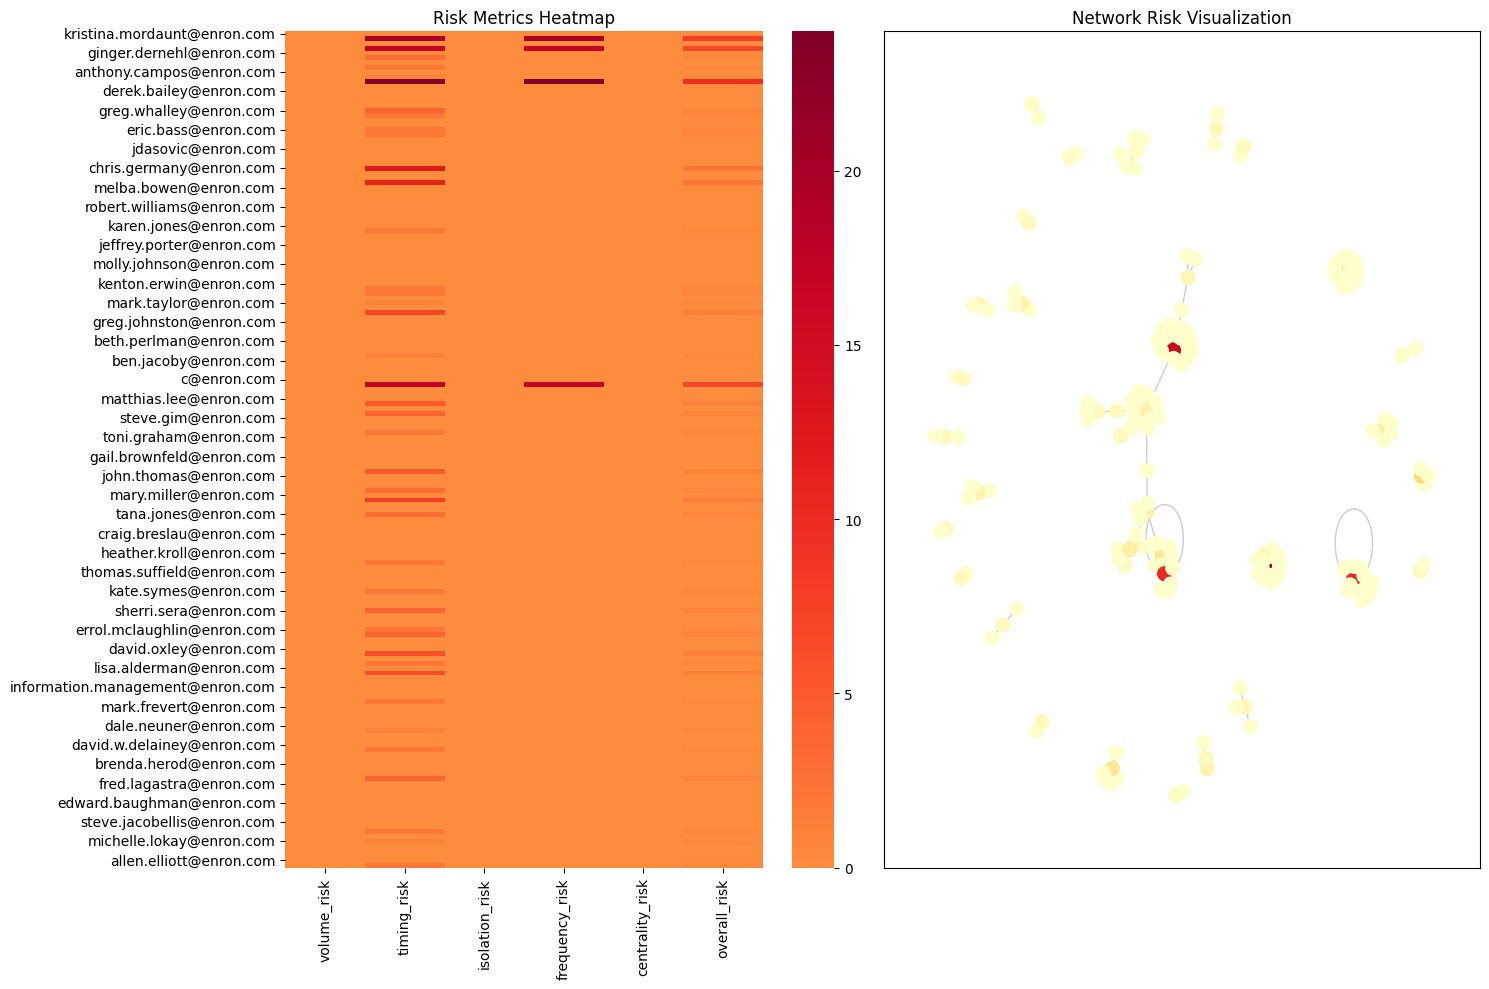


Risk Analysis Report for Period 1:
Risk Analysis Report

Number of entities analyzed: 174
Number of high-risk entities identified: 7
Average risk score: 0.324

Top Risk Indicators:

User: jason.williams@enron.com
Overall Risk Score: 9.60
Risk Factors:
- timing_risk: 24.00
- frequency_risk: 24.00

User: richard.sanders@enron.com
Overall Risk Score: 8.00
Risk Factors:
- timing_risk: 20.00
- frequency_risk: 20.00

User: kay.mann@enron.com
Overall Risk Score: 6.80
Risk Factors:
- timing_risk: 17.00
- frequency_risk: 17.00

User: vince.kaminski@enron.com
Overall Risk Score: 6.80
Risk Factors:
- timing_risk: 17.00
- frequency_risk: 17.00

User: chris.germany@enron.com
Overall Risk Score: 2.40
Risk Factors:
- timing_risk: 12.00

User: steven.kean@enron.com
Overall Risk Score: 2.20
Risk Factors:
- timing_risk: 11.00

User: susan.scott@enron.com
Overall Risk Score: 1.60
Risk Factors:
- timing_risk: 8.00

Period 2:
Date range: 1991-04-06 12:00:00 to 2002-07-12 00:00:00
Number of emails: 216135


/var/folders/_y/kn2v5b_s5yx4tqw5r5h4fwfc0000gn/T/ipykernel_46202/205821965.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network.emails_df['hour'] = pd.to_datetime(



Community Detection Summary:
Number of communities: 89
Modularity: 0.691
Average community size: 108.6
Size range: 1 to 2168
Average density: 0.670
Optimal resolution: 1.0

Period 2 Communities:
Number of communities: 89
Modularity: 0.691
Average community size: 108.6

Generating risk visualizations...


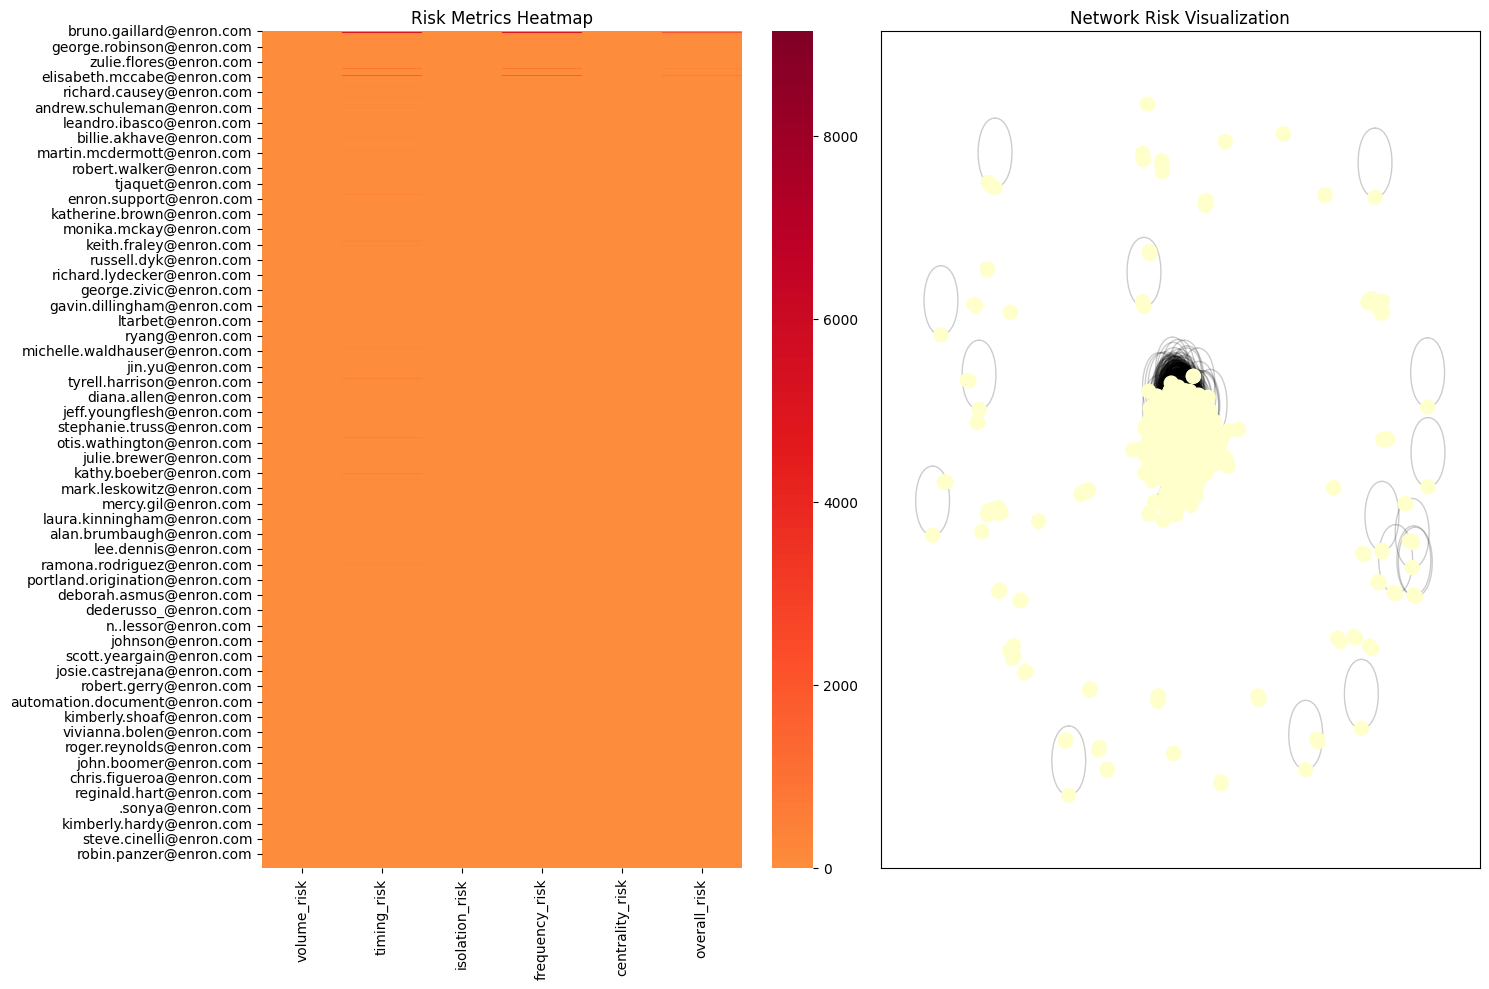


Risk Analysis Report for Period 2:
Risk Analysis Report

Number of entities analyzed: 9662
Number of high-risk entities identified: 73
Average risk score: 6.564

Top Risk Indicators:

User: pete.davis@enron.com
Overall Risk Score: 3657.20
Risk Factors:
- timing_risk: 9143.00
- frequency_risk: 9143.00

User: kay.mann@enron.com
Overall Risk Score: 2712.00
Risk Factors:
- timing_risk: 6780.00
- frequency_risk: 6780.00

User: jeff.dasovich@enron.com
Overall Risk Score: 2476.00
Risk Factors:
- timing_risk: 6190.00
- frequency_risk: 6190.00

User: tana.jones@enron.com
Overall Risk Score: 2284.80
Risk Factors:
- timing_risk: 5712.00
- frequency_risk: 5712.00

User: vince.kaminski@enron.com
Overall Risk Score: 2034.00
Risk Factors:
- timing_risk: 5085.00
- frequency_risk: 5085.00

User: sara.shackleton@enron.com
Overall Risk Score: 1955.60
Risk Factors:
- timing_risk: 4889.00
- frequency_risk: 4889.00

User: enron.announcements@enron.com
Overall Risk Score: 1836.40
Risk Factors:
- timing_risk

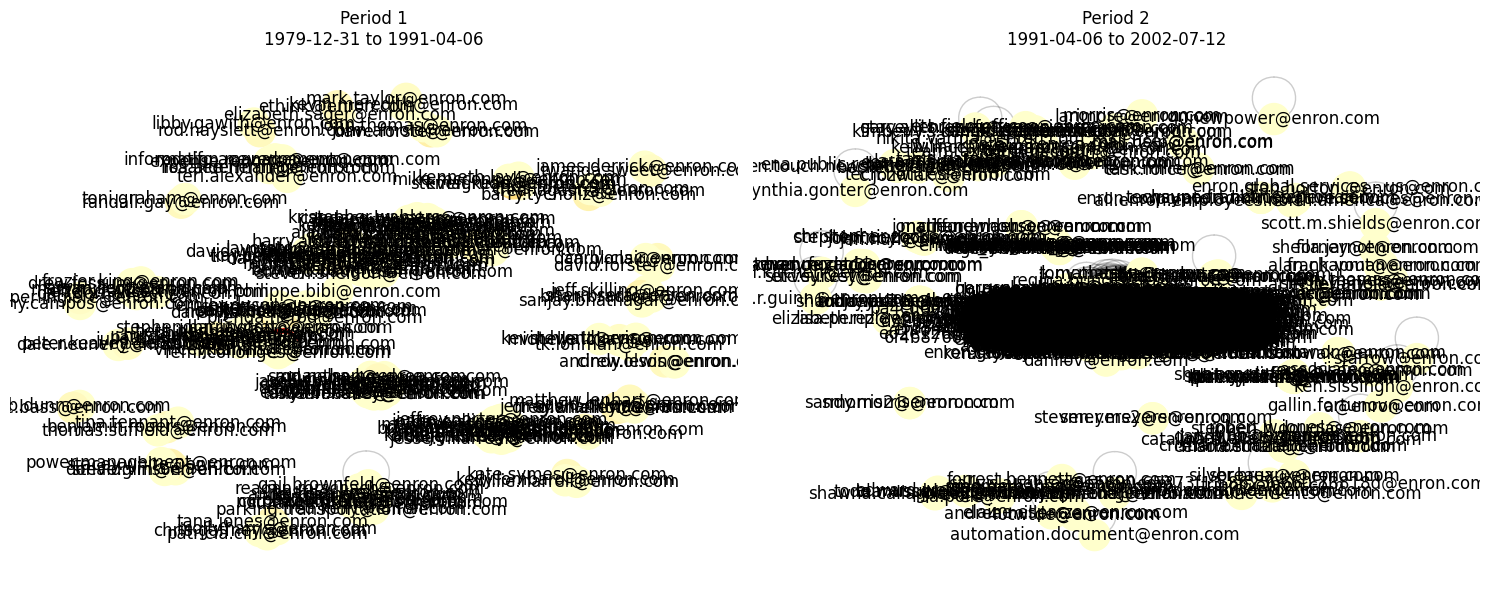


Step 4: Topic modeling...
Preprocessing email texts...
Building document-term matrix...
Training topic model...


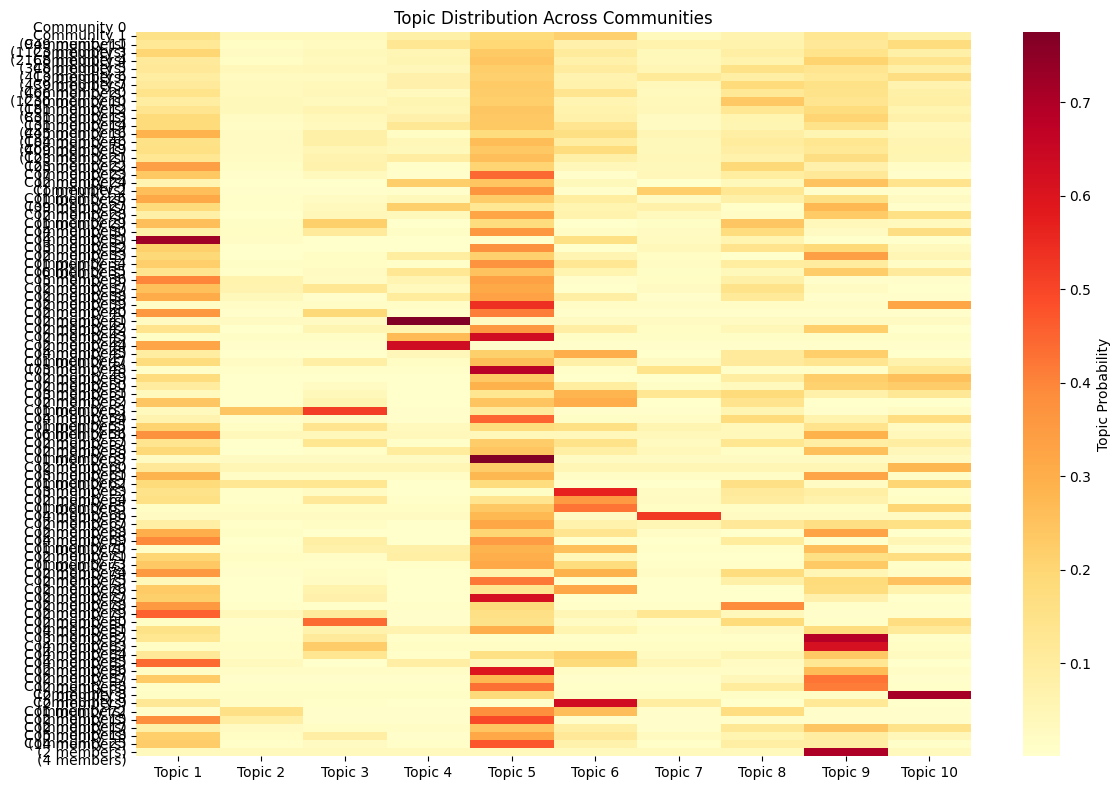


Community 0 (949 members):
Topic 6 top words: power, said, energy, company, state, market, would, new, california, electricity
Topic 5 top words: please, mail, let, call, thanks, know, questions, like, information, schedules
Topic 1 top words: meeting, group, business, new, management, team, process, enron_development, risk, services

Community 1 (1123 members):
Topic 5 top words: please, mail, let, call, thanks, know, questions, like, information, schedules
Topic 10 top words: error, agreement, attached, please, comments, credit, message, draft, doc, transactions
Topic 4 top words: ect, hou, ees, corp, forwarded, enronxgate, vince, sara, mark, mary

Community 11 (2168 members):
Topic 5 top words: please, mail, let, call, thanks, know, questions, like, information, schedules
Topic 1 top words: meeting, group, business, new, management, team, process, enron_development, risk, services
Topic 9 top words: would, get, one, think, week, could, going, back, want, know

Community 3 (348 memb

In [ ]:
def test_risk_detection(network):
    risk_analyzer = RiskAnalyzer(network)

    print("Analyzing communication risks...")
    risk_scores = risk_analyzer.analyze_communication_risks()
    
    print("\nAnalyzing content risks...")
    content_risks = risk_analyzer.analyze_content_risks()

    print("\nGenerating risk visualizations...")
    risk_analyzer.visualize_risks()

    print("\nRisk Analysis Report:")
    print(risk_analyzer.generate_risk_report())

def test_enron_network(path: str = "emails.csv"):
    test_df = pd.read_csv(path)
    
    network = EnronEmailNetwork(path)
    network.emails_df = test_df
    
    print("Step 1: Testing preprocessing...")
    network.preprocess_dataset()
    print(f"Processed emails: {len(network.emails_df)}")
    
    print("\nStep 2: Testing temporal splitting...")
    period_networks = network.split_network_by_time(2)
    
    period_communities = []
    period_risks = []
    
    for i, period in enumerate(period_networks):
        print(f"\nPeriod {i + 1}:")
        print(f"Date range: {period['start_date']} to {period['end_date']}")
        print(f"Number of emails: {period['num_emails']}")
        print(f"Number of nodes: {period['graph'].number_of_nodes()}")
        print(f"Number of edges: {period['graph'].number_of_edges()}")
        
        period_network = EnronEmailNetwork(None)
        period_network.emails_df = network.emails_df[
            (network.emails_df['date'] >= period['start_date']) &
            (network.emails_df['date'] < period['end_date'])
        ]
        period_network.graph = period['graph']
        
        print(f"\nAnalyzing risks for Period {i + 1}...")
        risk_analyzer = RiskAnalyzer(period_network)
        risk_scores = risk_analyzer.analyze_communication_risks()
        content_risks = risk_analyzer.analyze_content_risks()
        period_risks.append({
            'scores': risk_scores,
            'content': content_risks,
            'analyzer': risk_analyzer
        })
        
        communities = network.detect_communities(period['graph'], min_size=3)
        period_communities.append(communities)
        
        print(f"\nPeriod {i + 1} Communities:")
        print(f"Number of communities: {communities['metrics']['num_communities']}")
        print(f"Modularity: {communities['metrics']['modularity']:.3f}")
        print(f"Average community size: {communities['metrics']['avg_size']:.1f}")
        
        print("\nGenerating risk visualizations...")
        risk_analyzer.visualize_risks()
        
        print(f"\nRisk Analysis Report for Period {i + 1}:")
        print(risk_analyzer.generate_risk_report())
    
    print("\nStep 3: Visualizing network evolution...")
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, period in enumerate(period_networks):
        ax = axes[i]
        G = period['graph']
        pos = nx.spring_layout(G)
        
        risk_scores = period_risks[i]['scores']
        node_colors = []
        for node in G.nodes():
            if node in risk_scores:
                scores = risk_scores[node]
                avg_risk = np.mean(list(scores.values()))
                node_colors.append(avg_risk)
            else:
                node_colors.append(0)
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                             cmap=plt.cm.YlOrRd, node_size=500, ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        
        ax.set_title(f"Period {i + 1}\n{period['start_date'].date()} to {period['end_date'].date()}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('network_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nStep 4: Topic modeling...")
    network.build_topic_model(n_topics=10)
    community_topics = network.analyze_community_topics(period_communities[-1])
    network.visualize_community_topics()
    
    for comm_id, data in community_topics.items():
        print(f"\nCommunity {comm_id} ({data['size']} members):")
        for topic_idx in data['dominant_topics']:
            print(f"Topic {topic_idx + 1} top words:", ', '.join(data['topic_words'][topic_idx]))
            
    print("\nOverall Risk Analysis Summary:")
    print("============================")
    for i, period_risk in enumerate(period_risks):
        high_risk_users = {
            user: scores for user, scores in period_risk['scores'].items()
            if np.mean(list(scores.values())) > 0.5  # Threshold for high risk
        }
        print(f"\nPeriod {i + 1} High Risk Users: {len(high_risk_users)}")
        if high_risk_users:
            print("Top 5 highest risk users:")
            sorted_users = sorted(
                high_risk_users.items(),
                key=lambda x: np.mean(list(x[1].values())),
                reverse=True
            )[:5]
            for user, scores in sorted_users:
                print(f"- {user}: {np.mean(list(scores.values())):.3f}")

            
test_enron_network('emails.csv')